In [4]:
import lightgbm as lgb
import shap
from sklearn.metrics import average_precision_score, log_loss
from sklearn.model_selection import train_test_split
import dask.dataframe as dd
import os, sys
import time
import lightgbm as lgb
import gc
import pandas as pd
from dask.distributed import Client, LocalCluster
import matplotlib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score, log_loss


# Loading data and setting dataframe 

In [5]:
data_path = '../../data/train'

In [6]:
def start_cluster(n_workers=2, threads_per_worker=2, memory_limit="3GB", processes=True):
    cluster = LocalCluster(
        n_workers=n_workers, threads_per_worker=threads_per_worker, memory_limit=memory_limit, processes=processes
    )
    client = Client(cluster)  # use default n_threads and mem
    print(client)
    print(client.cluster)
    return client

In [5]:
c = start_cluster(n_workers=8, threads_per_worker=1, memory_limit="24GB", processes=True)

<Client: 'tcp://127.0.0.1:41523' processes=8 threads=8, memory=178.81 GiB>
LocalCluster(1f92c00e, 'tcp://127.0.0.1:41523', workers=8, threads=8, memory=178.81 GiB)


In [7]:
parquet_dataset_path = data_path


idx=0
engCols=['engagement_like_timestamp', 'engagement_retweet_timestamp','engagement_reply_timestamp', 'engagement_comment_timestamp']

#parquet_dataset_Test_path= os.path.join(RootPath.get_dataset_path(),"test")
print('Start reading \n')
cols=[
    'creator_follower_count',
        'creator_following_count',
        'creator_is_verified',
        'creator_creation_timestamp',
        'engager_follower_count',
        'engager_following_count',
        'engager_is_verified',
        'engager_creation_timestamp',
        'engagement_creator_follows_engager',
        'engagement_reply_timestamp',
        'engagement_retweet_timestamp',
        'engagement_comment_timestamp',
        'engagement_like_timestamp',
        'is_from_official_val',
        'number_of_photo',
        'number_of_gif',
        'number_of_video',
        'tweet_links_count',
        'tweet_domains_count',
        'tweet_hashtags_count',
        'tweet_hashtags_unique_count',
        'mapped_language_id',
        'mapped_tweet_type',
        'tweet_timestamp_hour_sin',
        'tweet_timestamp_hour_cos',
        'tweet_timestamp_day',
        'tweet_timestamp_weekday',
        'tweet_timestamp_hour_bin',
        'tweet_timestamp_creator_account_age_bin',
        'text_is_reply',
        'text_tokens_count',
        'text_unknown_count',
        'text_special_tokens_count',
        'text_questions_count',
        'text_semantic_separation',
        'text_newline_count',
        'text_separated_count',
        'text_char_count',
        'text_asking_like',
        'text_asking_reply',
        'text_comment_related_count',
        'text_no_comment_related_count',
        'text_asking_retweet',
        'text_nsfw_count',
        'text_kpop_count',
        'text_covid_count',
        'text_sports_count',
        'text_japanesetrending_count',
        'text_anime_count',
        'text_vtuber_count',
        'text_news_count',
        'text_myanmar_count',
        'text_genshin_count',
        'text_crypto_count',
        'text_trending_count',
        'text_love_count',
        'text_slang_count',
        'text_mention_count',
        'engager_follower_quantile',
        'creator_follower_quantile',
        'creator_follower_ratio',
        'engager_follower_ratio',
        'creator_vs_engager_follower_ratio',
        'creator_vs_engager_following_ratio',
        'CE_language__timestamp_hour_bin',
        'CE_language__timestamp_hour_bin__timestamp_weekday',
        'CE_language__type',
        'CE_language__engager_follower_quantile',
        'CE_type__timestamp_weekday',
        'CE_type__timestamp_hour_bin',
        'CE_timestamp_creator_account_age_bin__engager_follower_quantile__creator_follower_quantile',
        'CE_language__presence_of_photo__presence_of_gif__presence_of_video',
        'TE_mapped_engager_id_engagement_reply',
        'TE_number_of_photo_engagement_reply',
        'TE_number_of_gif_engagement_reply',
        'TE_number_of_video_engagement_reply',
        'TE_mapped_tweet_type_engagement_reply',
        'TE_mapped_language_id_engagement_reply',
        'TE_mapped_creator_id_engagement_reply',
        'TE_mapped_tweet_links_id_1_engagement_reply',
        'TE_mapped_tweet_links_id_2_engagement_reply',
        'TE_mapped_tweet_hashtags_id_1_engagement_reply',
        'TE_mapped_tweet_hashtags_id_2_engagement_reply',
        'TE_mapped_domains_id_1_engagement_reply',
        'TE_mapped_domains_id_2_engagement_reply',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_reply",
        'TE_tweet_links_count_engagement_reply',
        'TE_tweet_domains_count_engagement_reply',
        'TE_tweet_hashtags_count_engagement_reply',
        'TE_tweet_hashtags_unique_count_engagement_reply',
        'TE_mapped_engager_id_engagement_retweet',
        'TE_number_of_photo_engagement_retweet',
        'TE_number_of_gif_engagement_retweet',
        'TE_number_of_video_engagement_retweet',
        'TE_mapped_tweet_type_engagement_retweet',
        'TE_mapped_language_id_engagement_retweet',
        'TE_mapped_creator_id_engagement_retweet',
        'TE_mapped_tweet_links_id_1_engagement_retweet',
        'TE_mapped_tweet_links_id_2_engagement_retweet',
        'TE_mapped_tweet_hashtags_id_1_engagement_retweet',
        'TE_mapped_tweet_hashtags_id_2_engagement_retweet',
        'TE_mapped_domains_id_1_engagement_retweet',
        'TE_mapped_domains_id_2_engagement_retweet',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_retweet",
        'TE_tweet_links_count_engagement_retweet',
        'TE_tweet_domains_count_engagement_retweet',
        'TE_tweet_hashtags_count_engagement_retweet',
        'TE_tweet_hashtags_unique_count_engagement_retweet',
        'TE_mapped_engager_id_engagement_comment',
        'TE_number_of_photo_engagement_comment',
        'TE_number_of_gif_engagement_comment',
        'TE_number_of_video_engagement_comment',
        'TE_mapped_tweet_type_engagement_comment',
        'TE_mapped_language_id_engagement_comment',
        'TE_mapped_creator_id_engagement_comment',
        'TE_mapped_tweet_links_id_1_engagement_comment',
        'TE_mapped_tweet_links_id_2_engagement_comment',
        'TE_mapped_tweet_hashtags_id_1_engagement_comment',
        'TE_mapped_tweet_hashtags_id_2_engagement_comment',
        'TE_mapped_domains_id_1_engagement_comment',
        'TE_mapped_domains_id_2_engagement_comment',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_comment",
        'TE_tweet_links_count_engagement_comment',
        'TE_tweet_domains_count_engagement_comment',
        'TE_tweet_hashtags_count_engagement_comment',
        'TE_tweet_hashtags_unique_count_engagement_comment',
        'TE_mapped_engager_id_engagement_like',
        'TE_number_of_photo_engagement_like',
        'TE_number_of_gif_engagement_like',
        'TE_number_of_video_engagement_like',
        'TE_mapped_tweet_type_engagement_like',
        'TE_mapped_language_id_engagement_like',
        'TE_mapped_creator_id_engagement_like',
        'TE_mapped_tweet_links_id_1_engagement_like',
        'TE_mapped_tweet_links_id_2_engagement_like',
        'TE_mapped_tweet_hashtags_id_1_engagement_like',
        'TE_mapped_tweet_hashtags_id_2_engagement_like',
        'TE_mapped_domains_id_1_engagement_like',
        'TE_mapped_domains_id_2_engagement_like',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_like",
        'TE_tweet_links_count_engagement_like',
        'TE_tweet_domains_count_engagement_like',
        'TE_tweet_hashtags_count_engagement_like',
        'TE_tweet_hashtags_unique_count_engagement_like',
        'engager_hashtag_count_all_avg',
        'engager_hashtag_count_all_max',
        'engager_hashtag_count_reply_avg',
        'engager_hashtag_count_reply_max',
        'engager_hashtag_count_retweet_avg',
        'engager_hashtag_count_retweet_max',
        'engager_hashtag_count_comment_avg',
        'engager_hashtag_count_comment_max',
        'engager_hashtag_count_like_avg',
        'engager_hashtag_count_like_max',
        'engager_language_count_all',
        'engager_language_count_reply',
        'engager_language_count_retweet',
        'engager_language_count_comment',
        'engager_language_count_like',
        'engager_photo_count_all',
        'engager_photo_count_reply',
        'engager_photo_count_retweet',
        'engager_photo_count_comment',
        'engager_photo_count_like',
        'engager_gif_count_all',
        'engager_gif_count_reply',
        'engager_gif_count_retweet',
        'engager_gif_count_comment',
        'engager_gif_count_like',
        'engager_video_count_all',
        'engager_video_count_reply',
        'engager_video_count_retweet',
        'engager_video_count_comment',
        'engager_video_count_like',
        'engager_type_count_all',
        'engager_type_count_reply',
        'engager_type_count_retweet',
        'engager_type_count_comment',
        'engager_type_count_like',
        'language_hourbin_count_all',
        'language_hourbin_count_reply',
        'language_hourbin_count_retweet',
        'language_hourbin_count_comment',
        'language_hourbin_count_like',
        'engager_weekday_count_all',
        'engager_weekday_count_reply',
        'engager_weekday_count_retweet',
        'engager_weekday_count_comment',
        'engager_weekday_count_like'
 ]

df = dd.read_parquet(parquet_dataset_path, engine='fastparquet', columns=cols)

#dfTest = dd.read_parquet(parquet_dataset_Test_path, engine='fastparquet', columns=cols)

df = df.sample(frac = 0.1)

df.columns=[c.replace("'",'_').replace(",","_") for c in df.columns]

# Drop other engagements
chosen=engCols[idx]
rest=[c for c in engCols if c!=chosen]
# Drop other engagements
df = df.drop(columns=rest)

df[chosen] = df[chosen].mask(df[chosen] < 0, 0)
df[chosen] = df[chosen].mask(df[chosen] > 0, 1)

y = df[chosen]
df = df.drop(columns=[chosen])

print('Start compute \n')
# From Dask to Pandas
df = df.compute()
y = y.compute()



Start reading 

Start compute 



# Loading Models

In [3]:
# Like model feature importance
like_path = '../LightGBM_training_final_dataset/LightGBM_like/lightgbm_like_1624480146.7227838.txt'
retweet_path = '../LightGBM_training_final_dataset/LightGBM_retweet/lightgbm_retweet_1624481196.9369323.txt'
reply_path = '../LightGBM_training_final_dataset/LightGBM_reply/lightgbm_reply_1624481210.4095285.txt'
comment_path = '../LightGBM_training_final_dataset/LightGBM_comment/lightgbm_comment_1624481846.83218.txt'

path_list = [like_path, retweet_path, reply_path, comment_path]
models_list = []

for path in path_list:
    model = lgb.Booster(model_file = path)
    models_list.append(model)


# Computing feature importance from lightGBM (standard importances)

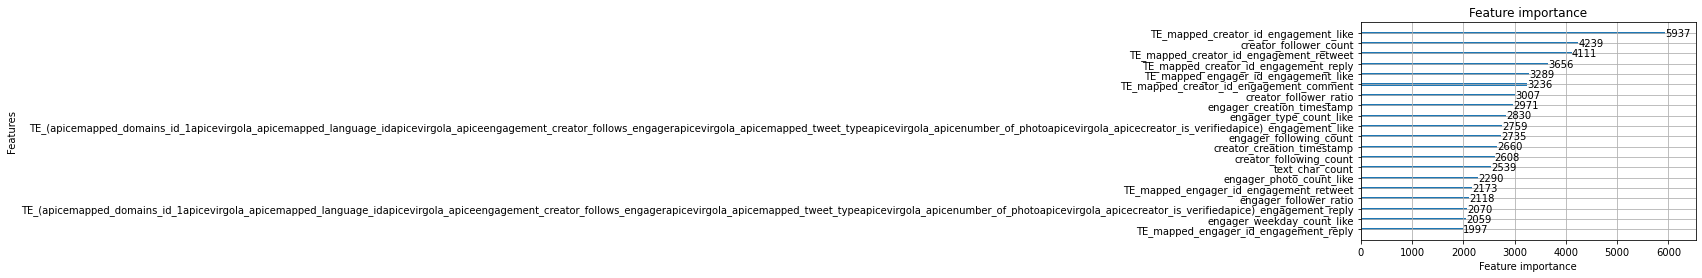

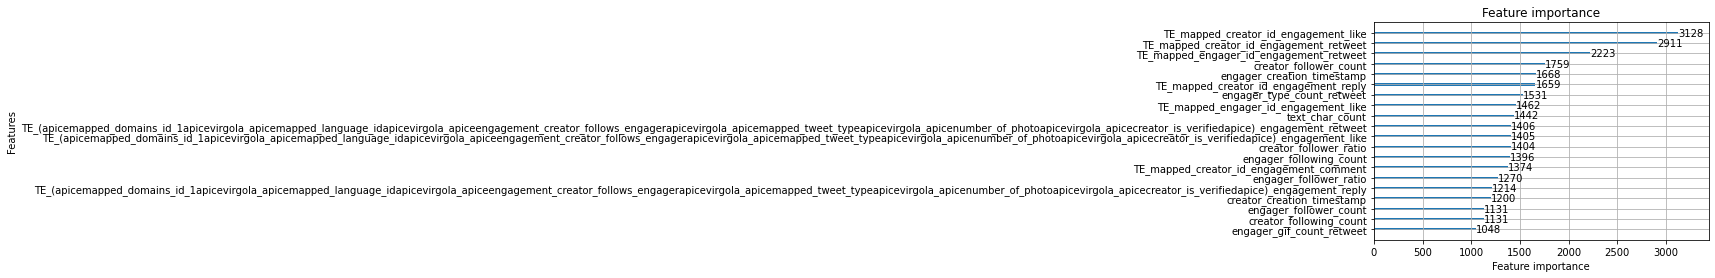

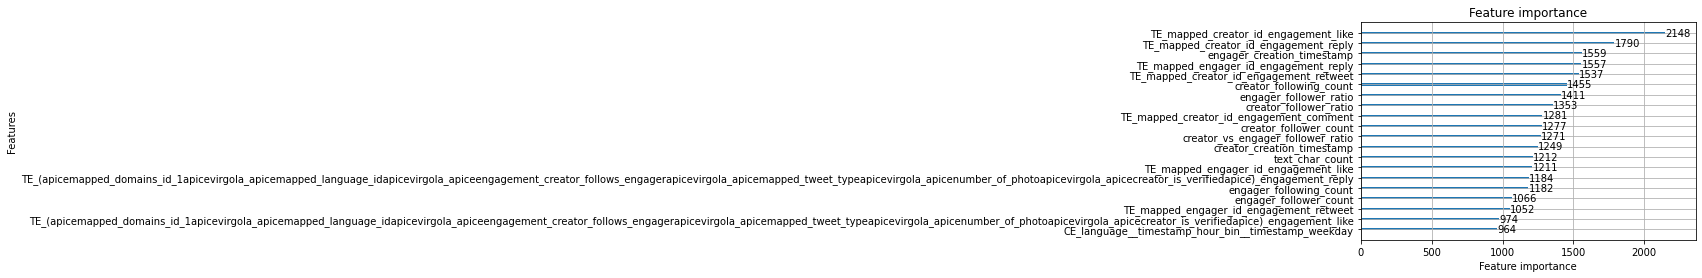

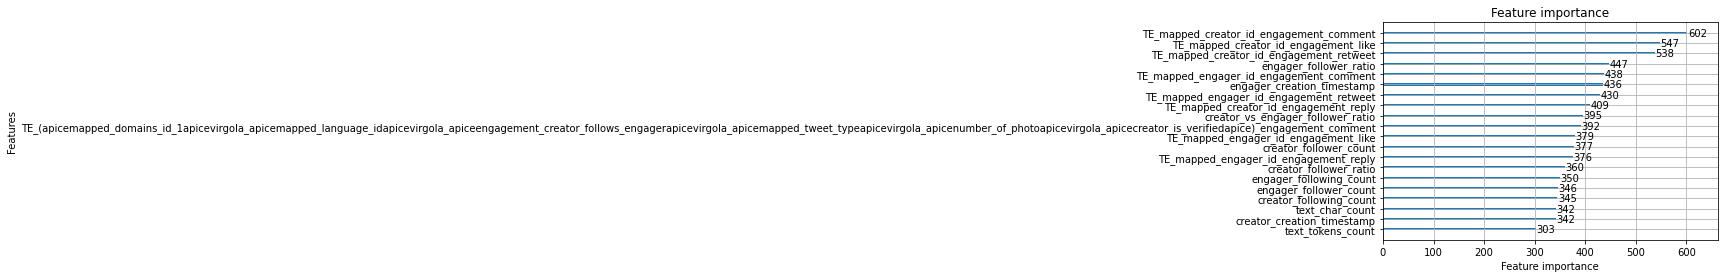

In [7]:
for model in models_list:
    lgb.plot_importance(model, max_num_features=20)

# Computing feature importances with shap

In [10]:
models_list[0].params['objective'] = 'binary'
explainer = shap.TreeExplainer(models_list[0])
shap_values = explainer.shap_values(df)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


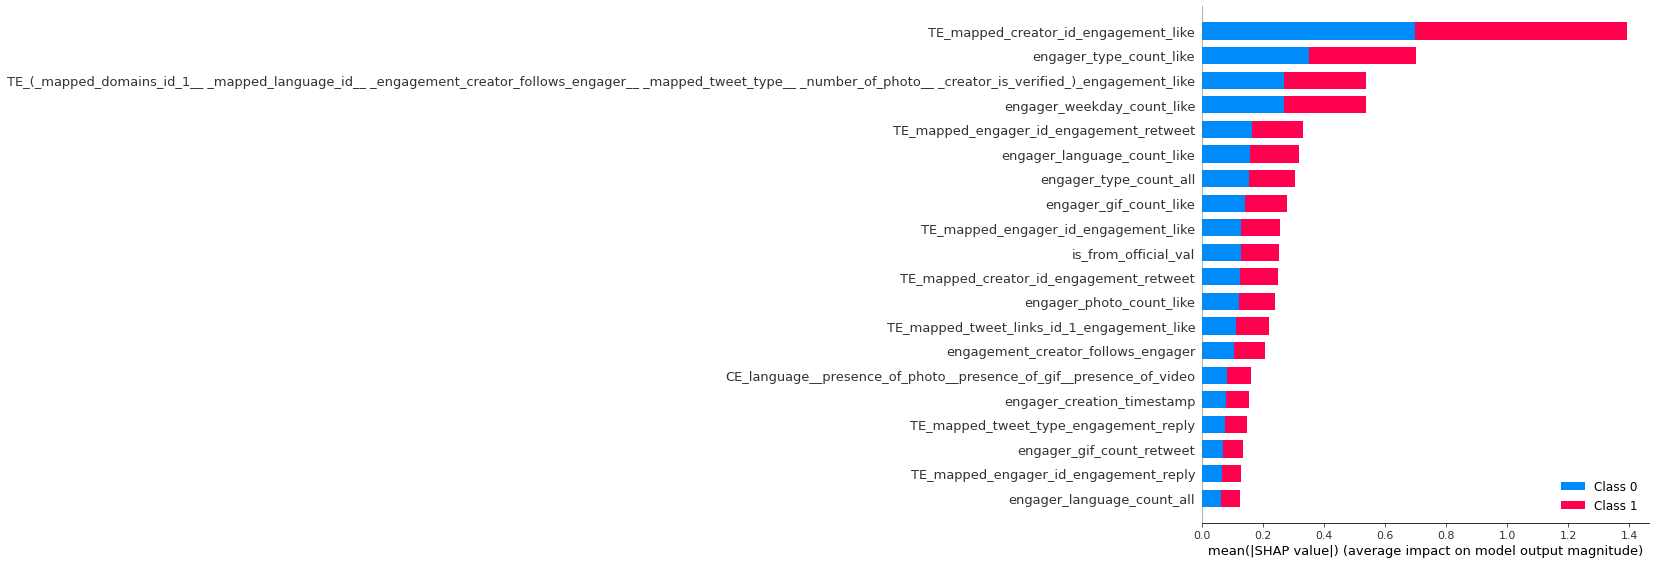

In [11]:
shap.summary_plot(shap_values, df)

In [15]:
models_list[1].params['objective'] = 'binary'
explainer = shap.TreeExplainer(models_list[1])
shap_values = explainer.shap_values(df)

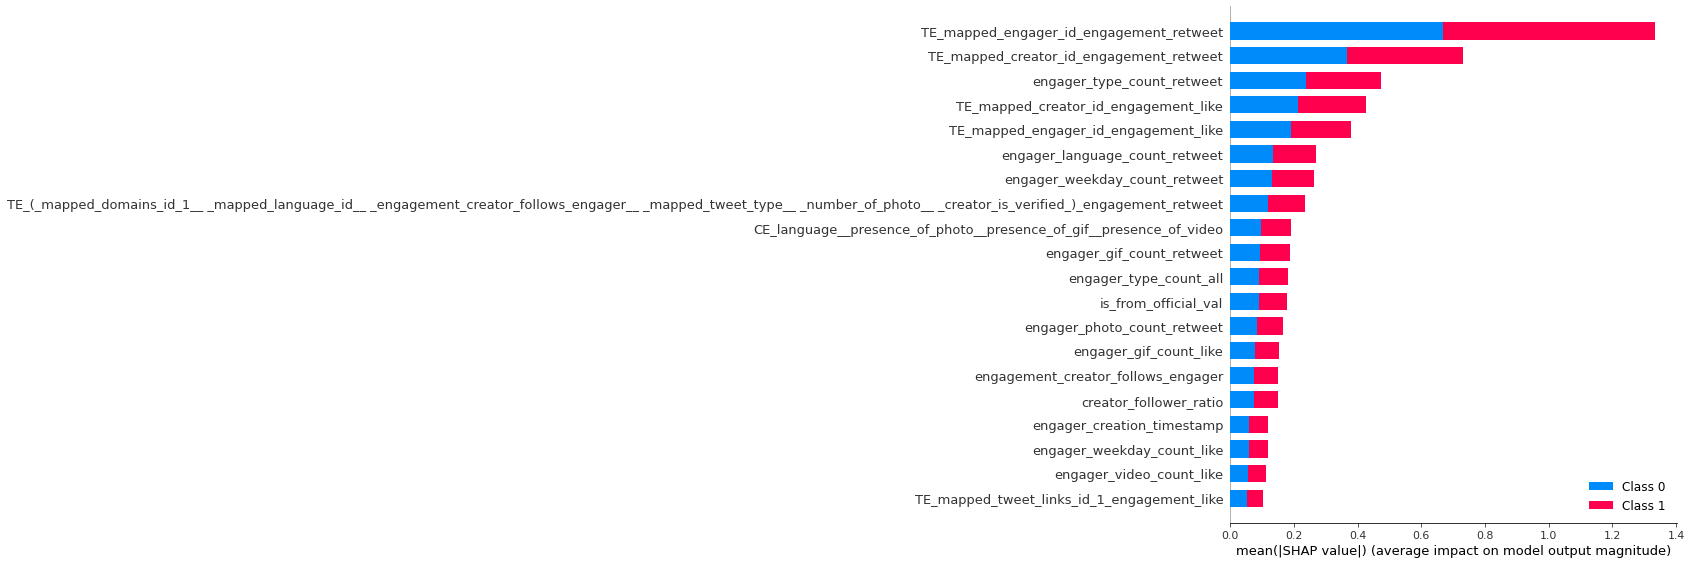

In [16]:
shap.summary_plot(shap_values, df)

In [17]:
models_list[2].params['objective'] = 'binary'
explainer = shap.TreeExplainer(models_list[2])
shap_values = explainer.shap_values(df)

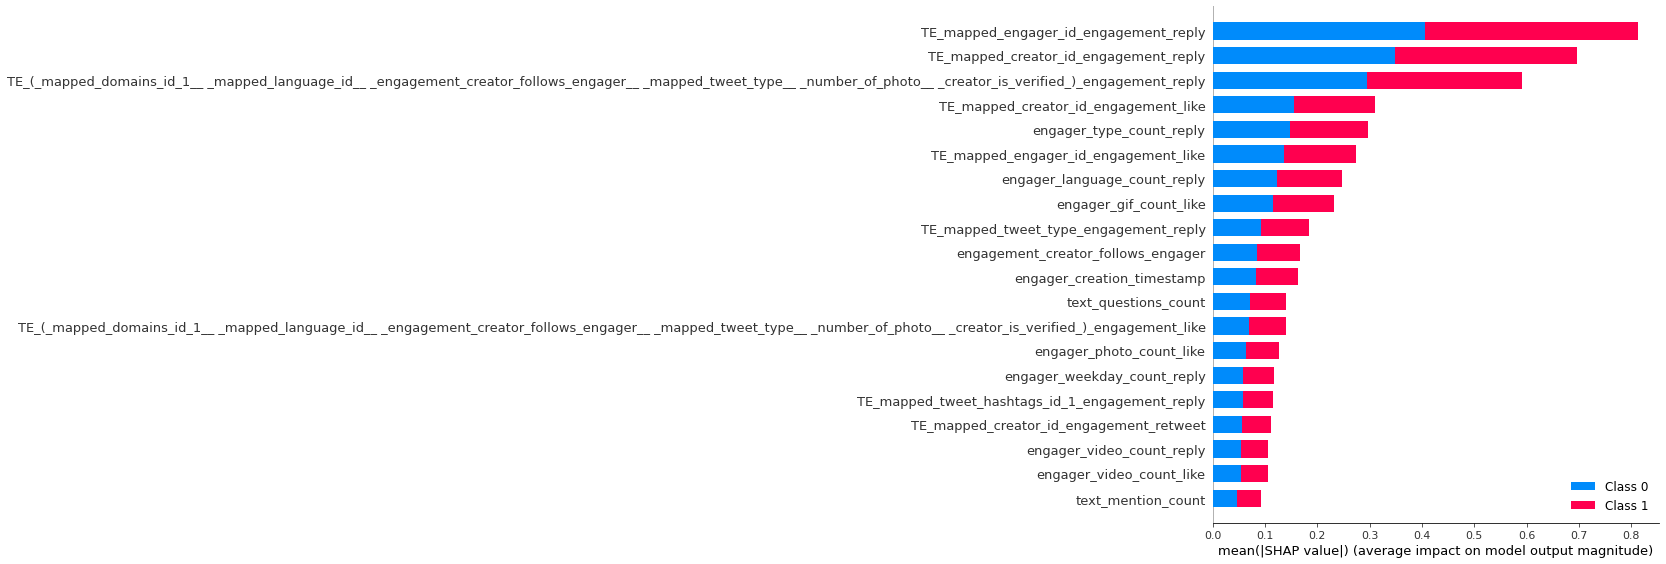

In [18]:
shap.summary_plot(shap_values, df)

In [19]:
models_list[3].params['objective'] = 'binary'
explainer = shap.TreeExplainer(models_list[3])
shap_values = explainer.shap_values(df)

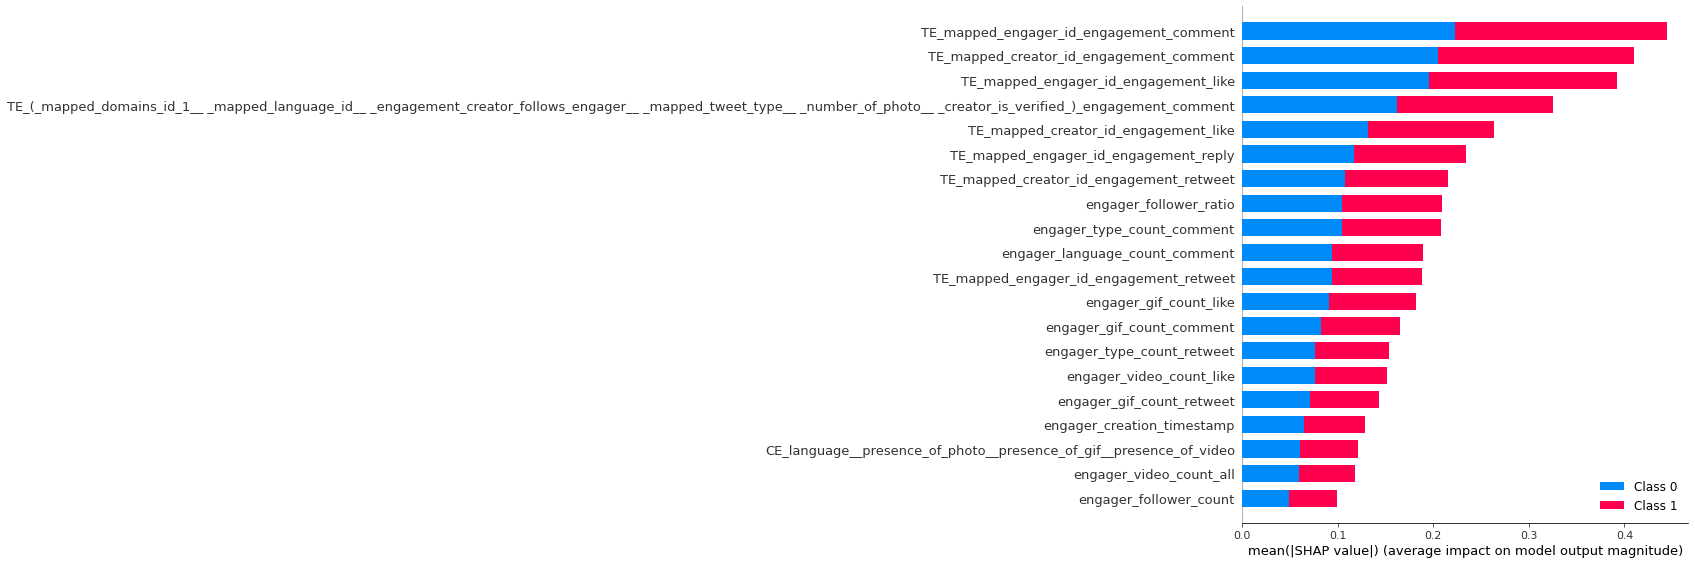

In [20]:
shap.summary_plot(shap_values, df)

# Feature importance with eli5 

NB: following ```explain_weights_lightgbm(..., importance_type = 'split')``` contains the same identical data of     ```lgb.plot_importance(model, ...)```. 

In [10]:
clf = lgb.LGBMClassifier()

### Like Model

In [11]:
clf._Booster = models_list[0]
eli5.explain_weights_lightgbm(clf, top=30)

Weight,Feature
0.4264,TE_mapped_creator_id_engagement_like
0.1112,TE_(apicemapped_domains_id_1apicevirgola_apicemapped_language_idapicevirgola_apiceengagement_creator_follows_engagerapicevirgola_apicemapped_tweet_typeapicevirgola_apicenumber_of_photoapicevirgola_apicecreator_is_verifiedapice)_engagement_like
0.0585,TE_mapped_engager_id_engagement_like
0.0387,engager_type_count_like
0.0253,is_from_official_val
0.0223,TE_mapped_engager_id_engagement_retweet
0.0213,engager_weekday_count_like
0.0193,TE_mapped_tweet_links_id_1_engagement_like
0.0183,TE_mapped_creator_id_engagement_retweet
0.0153,creator_follower_count


In [22]:
eli5.explain_weights_lightgbm(clf, top=50,  importance_type='split')

Weight,Feature
0.0473,TE_mapped_creator_id_engagement_like
0.0338,creator_follower_count
0.0328,TE_mapped_creator_id_engagement_retweet
0.0291,TE_mapped_creator_id_engagement_reply
0.0262,TE_mapped_engager_id_engagement_like
0.0258,TE_mapped_creator_id_engagement_comment
0.0240,creator_follower_ratio
0.0237,engager_creation_timestamp
0.0225,engager_type_count_like
0.0220,TE_(apicemapped_domains_id_1apicevirgola_apicemapped_language_idapicevirgola_apiceengagement_creator_follows_engagerapicevirgola_apicemapped_tweet_typeapicevirgola_apicenumber_of_photoapicevirgola_apicecreator_is_verifiedapice)_engagement_like


### Retweet Model

In [26]:
clf._Booster = models_list[1]
eli5.explain_weights_lightgbm(clf, top=30)

Weight,Feature
0.4855,TE_mapped_engager_id_engagement_retweet
0.2078,TE_mapped_creator_id_engagement_retweet
0.0325,TE_mapped_creator_id_engagement_like
0.0290,engager_type_count_retweet
0.0190,TE_mapped_engager_id_engagement_like
0.0144,TE_(apicemapped_domains_id_1apicevirgola_apicemapped_language_idapicevirgola_apiceengagement_creator_follows_engagerapicevirgola_apicemapped_tweet_typeapicevirgola_apicenumber_of_photoapicevirgola_apicecreator_is_verifiedapice)_engagement_retweet
0.0123,engager_gif_count_like
0.0091,TE_(apicemapped_domains_id_1apicevirgola_apicemapped_language_idapicevirgola_apiceengagement_creator_follows_engagerapicevirgola_apicemapped_tweet_typeapicevirgola_apicenumber_of_photoapicevirgola_apicecreator_is_verifiedapice)_engagement_like
0.0091,engager_language_count_retweet
0.0077,TE_mapped_tweet_links_id_1_engagement_retweet


In [25]:
eli5.explain_weights_lightgbm(clf, top=50,  importance_type='split')

Weight,Feature
0.0449,TE_mapped_creator_id_engagement_like
0.0418,TE_mapped_creator_id_engagement_retweet
0.0319,TE_mapped_engager_id_engagement_retweet
0.0253,creator_follower_count
0.0240,engager_creation_timestamp
0.0238,TE_mapped_creator_id_engagement_reply
0.0220,engager_type_count_retweet
0.0210,TE_mapped_engager_id_engagement_like
0.0207,text_char_count
0.0202,TE_(apicemapped_domains_id_1apicevirgola_apicemapped_language_idapicevirgola_apiceengagement_creator_follows_engagerapicevirgola_apicemapped_tweet_typeapicevirgola_apicenumber_of_photoapicevirgola_apicecreator_is_verifiedapice)_engagement_retweet


### Reply Model

In [28]:
clf._Booster = models_list[2]
eli5.explain_weights_lightgbm(clf, top=30)

Weight,Feature
0.2576,TE_mapped_engager_id_engagement_reply
0.1576,TE_mapped_creator_id_engagement_reply
0.1306,TE_(apicemapped_domains_id_1apicevirgola_apicemapped_language_idapicevirgola_apiceengagement_creator_follows_engagerapicevirgola_apicemapped_tweet_typeapicevirgola_apicenumber_of_photoapicevirgola_apicecreator_is_verifiedapice)_engagement_reply
0.0494,engager_gif_count_like
0.0353,engager_type_count_reply
0.0297,TE_(apicemapped_domains_id_1apicevirgola_apicemapped_language_idapicevirgola_apiceengagement_creator_follows_engagerapicevirgola_apicemapped_tweet_typeapicevirgola_apicenumber_of_photoapicevirgola_apicecreator_is_verifiedapice)_engagement_like
0.0225,engager_language_count_reply
0.0145,TE_mapped_creator_id_engagement_like
0.0145,TE_mapped_engager_id_engagement_like
0.0131,TE_mapped_tweet_type_engagement_comment


In [29]:
eli5.explain_weights_lightgbm(clf, top=50,  importance_type='split')

Weight,Feature
0.0339,TE_mapped_creator_id_engagement_like
0.0283,TE_mapped_creator_id_engagement_reply
0.0246,engager_creation_timestamp
0.0246,TE_mapped_engager_id_engagement_reply
0.0243,TE_mapped_creator_id_engagement_retweet
0.0230,creator_following_count
0.0223,engager_follower_ratio
0.0214,creator_follower_ratio
0.0202,TE_mapped_creator_id_engagement_comment
0.0202,creator_follower_count


### Comment Model

In [30]:
clf._Booster = models_list[3]
eli5.explain_weights_lightgbm(clf, top=30)

Weight,Feature
0.1169,engager_language_count_comment
0.1149,TE_mapped_creator_id_engagement_comment
0.0914,engager_type_count_comment
0.0779,TE_mapped_engager_id_engagement_comment
0.0586,engager_language_count_like
0.0398,engager_gif_count_comment
0.0265,TE_mapped_engager_id_engagement_like
0.0250,TE_mapped_creator_id_engagement_retweet
0.0234,TE_(apicemapped_domains_id_1apicevirgola_apicemapped_language_idapicevirgola_apiceengagement_creator_follows_engagerapicevirgola_apicemapped_tweet_typeapicevirgola_apicenumber_of_photoapicevirgola_apicecreator_is_verifiedapice)_engagement_comment
0.0226,engager_video_count_all


In [31]:
eli5.explain_weights_lightgbm(clf, top=50,  importance_type='split')

Weight,Feature
0.0296,TE_mapped_creator_id_engagement_comment
0.0269,TE_mapped_creator_id_engagement_like
0.0265,TE_mapped_creator_id_engagement_retweet
0.0220,engager_follower_ratio
0.0215,TE_mapped_engager_id_engagement_comment
0.0214,engager_creation_timestamp
0.0211,TE_mapped_engager_id_engagement_retweet
0.0201,TE_mapped_creator_id_engagement_reply
0.0194,creator_vs_engager_follower_ratio
0.0193,TE_(apicemapped_domains_id_1apicevirgola_apicemapped_language_idapicevirgola_apiceengagement_creator_follows_engagerapicevirgola_apicemapped_tweet_typeapicevirgola_apicenumber_of_photoapicevirgola_apicecreator_is_verifiedapice)_engagement_comment


# Permutation importance with eli5

In [16]:
#Custom scorer

#def rce(estimator, y_true, y_pred):
def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def rce_scorer(estimator, X, y):
    cross_entropy = log_loss(y, estimator.predict_proba(X))
    data_ctr = calculate_ctr(y)
    strawman_cross_entropy = log_loss(y, [data_ctr for _ in range(len(y))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

#custom_scorer_rce = make_scorer(rce, greater_is_better=True)


### Premutation importance Like

In [10]:
from sklearn.metrics import average_precision_score, log_loss
from sklearn.model_selection import train_test_split
import dask.dataframe as dd
import os, sys
import time
import lightgbm as lgb
import gc
import pandas as pd



def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr


def rce(y_true, y_pred):
    cross_entropy = log_loss(y_true, y_pred)
    data_ctr = calculate_ctr(y_true)
    strawman_cross_entropy = log_loss(y_true, [data_ctr for _ in range(len(y_true))])
    return 'RCE', (1.0 - cross_entropy/strawman_cross_entropy)*100.0, False


def ap(y_true, y_pred):
    return 'AP', average_precision_score(y_true, y_pred), False


if __name__ == '__main__':
    print('Python %s on %s' % (sys.version, sys.platform))

    #change here to select the model to train.
    idx=0
    engCols=['engagement_like_timestamp', 'engagement_retweet_timestamp','engagement_reply_timestamp', 'engagement_comment_timestamp']

    
    c = start_cluster(n_workers=8, threads_per_worker=1, memory_limit="24GB", processes=True)

    # TBD: correct the path with the real one!
    parquet_dataset_path = os.path.join('../../data',"train")
    parquet_dataset_Test_path= os.path.join('../../data',"test")
    print('Start reading \n')
    cols = [
        'creator_follower_count',
        'creator_following_count',
        'creator_is_verified',
        'creator_creation_timestamp',
        'engager_follower_count',
        'engager_following_count',
        'engager_is_verified',
        'engager_creation_timestamp',
        'engagement_creator_follows_engager',
        'engagement_reply_timestamp',
        'engagement_retweet_timestamp',
        'engagement_comment_timestamp',
        'engagement_like_timestamp',
        'is_from_official_val',
        'number_of_photo',
        'number_of_gif',
        'number_of_video',
        'tweet_links_count',
        'tweet_domains_count',
        'tweet_hashtags_count',
        'tweet_hashtags_unique_count',
        'mapped_language_id',
        'mapped_tweet_type',
        'tweet_timestamp_hour_sin',
        'tweet_timestamp_hour_cos',
        'tweet_timestamp_day',
        'tweet_timestamp_weekday',
        'tweet_timestamp_hour_bin',
        'tweet_timestamp_creator_account_age_bin',
        'text_is_reply',
        'text_tokens_count',
        'text_unknown_count',
        'text_special_tokens_count',
        'text_questions_count',
        'text_semantic_separation',
        'text_newline_count',
        'text_separated_count',
        'text_char_count',
        'text_asking_like',
        'text_asking_reply',
        'text_comment_related_count',
        'text_no_comment_related_count',
        'text_asking_retweet',
        'text_nsfw_count',
        'text_kpop_count',
        'text_covid_count',
        'text_sports_count',
        'text_japanesetrending_count',
        'text_anime_count',
        'text_vtuber_count',
        'text_news_count',
        'text_myanmar_count',
        'text_genshin_count',
        'text_crypto_count',
        'text_trending_count',
        'text_love_count',
        'text_slang_count',
        'text_mention_count',
        'engager_follower_quantile',
        'creator_follower_quantile',
        'creator_follower_ratio',
        'engager_follower_ratio',
        'creator_vs_engager_follower_ratio',
        'creator_vs_engager_following_ratio',
        'CE_language__timestamp_hour_bin',
        'CE_language__timestamp_hour_bin__timestamp_weekday',
        'CE_language__type',
        'CE_language__engager_follower_quantile',
        'CE_type__timestamp_weekday',
        'CE_type__timestamp_hour_bin',
        'CE_timestamp_creator_account_age_bin__engager_follower_quantile__creator_follower_quantile',
        'CE_language__presence_of_photo__presence_of_gif__presence_of_video',
        'TE_mapped_engager_id_engagement_reply',
        'TE_number_of_photo_engagement_reply',
        'TE_number_of_gif_engagement_reply',
        'TE_number_of_video_engagement_reply',
        'TE_mapped_tweet_type_engagement_reply',
        'TE_mapped_language_id_engagement_reply',
        'TE_mapped_creator_id_engagement_reply',
        'TE_mapped_tweet_links_id_1_engagement_reply',
        'TE_mapped_tweet_links_id_2_engagement_reply',
        'TE_mapped_tweet_hashtags_id_1_engagement_reply',
        'TE_mapped_tweet_hashtags_id_2_engagement_reply',
        'TE_mapped_domains_id_1_engagement_reply',
        'TE_mapped_domains_id_2_engagement_reply',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_reply",
        'TE_tweet_links_count_engagement_reply',
        'TE_tweet_domains_count_engagement_reply',
        'TE_tweet_hashtags_count_engagement_reply',
        'TE_tweet_hashtags_unique_count_engagement_reply',
        'TE_mapped_engager_id_engagement_retweet',
        'TE_number_of_photo_engagement_retweet',
        'TE_number_of_gif_engagement_retweet',
        'TE_number_of_video_engagement_retweet',
        'TE_mapped_tweet_type_engagement_retweet',
        'TE_mapped_language_id_engagement_retweet',
        'TE_mapped_creator_id_engagement_retweet',
        'TE_mapped_tweet_links_id_1_engagement_retweet',
        'TE_mapped_tweet_links_id_2_engagement_retweet',
        'TE_mapped_tweet_hashtags_id_1_engagement_retweet',
        'TE_mapped_tweet_hashtags_id_2_engagement_retweet',
        'TE_mapped_domains_id_1_engagement_retweet',
        'TE_mapped_domains_id_2_engagement_retweet',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_retweet",
        'TE_tweet_links_count_engagement_retweet',
        'TE_tweet_domains_count_engagement_retweet',
        'TE_tweet_hashtags_count_engagement_retweet',
        'TE_tweet_hashtags_unique_count_engagement_retweet',
        'TE_mapped_engager_id_engagement_comment',
        'TE_number_of_photo_engagement_comment',
        'TE_number_of_gif_engagement_comment',
        'TE_number_of_video_engagement_comment',
        'TE_mapped_tweet_type_engagement_comment',
        'TE_mapped_language_id_engagement_comment',
        'TE_mapped_creator_id_engagement_comment',
        'TE_mapped_tweet_links_id_1_engagement_comment',
        'TE_mapped_tweet_links_id_2_engagement_comment',
        'TE_mapped_tweet_hashtags_id_1_engagement_comment',
        'TE_mapped_tweet_hashtags_id_2_engagement_comment',
        'TE_mapped_domains_id_1_engagement_comment',
        'TE_mapped_domains_id_2_engagement_comment',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_comment",
        'TE_tweet_links_count_engagement_comment',
        'TE_tweet_domains_count_engagement_comment',
        'TE_tweet_hashtags_count_engagement_comment',
        'TE_tweet_hashtags_unique_count_engagement_comment',
        'TE_mapped_engager_id_engagement_like',
        'TE_number_of_photo_engagement_like',
        'TE_number_of_gif_engagement_like',
        'TE_number_of_video_engagement_like',
        'TE_mapped_tweet_type_engagement_like',
        'TE_mapped_language_id_engagement_like',
        'TE_mapped_creator_id_engagement_like',
        'TE_mapped_tweet_links_id_1_engagement_like',
        'TE_mapped_tweet_links_id_2_engagement_like',
        'TE_mapped_tweet_hashtags_id_1_engagement_like',
        'TE_mapped_tweet_hashtags_id_2_engagement_like',
        'TE_mapped_domains_id_1_engagement_like',
        'TE_mapped_domains_id_2_engagement_like',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_like",
        'TE_tweet_links_count_engagement_like',
        'TE_tweet_domains_count_engagement_like',
        'TE_tweet_hashtags_count_engagement_like',
        'TE_tweet_hashtags_unique_count_engagement_like',
        'engager_hashtag_count_all_avg',
        'engager_hashtag_count_all_max',
        'engager_hashtag_count_reply_avg',
        'engager_hashtag_count_reply_max',
        'engager_hashtag_count_retweet_avg',
        'engager_hashtag_count_retweet_max',
        'engager_hashtag_count_comment_avg',
        'engager_hashtag_count_comment_max',
        'engager_hashtag_count_like_avg',
        'engager_hashtag_count_like_max',
        'engager_language_count_all',
        'engager_language_count_reply',
        'engager_language_count_retweet',
        'engager_language_count_comment',
        'engager_language_count_like',
        'engager_photo_count_all',
        'engager_photo_count_reply',
        'engager_photo_count_retweet',
        'engager_photo_count_comment',
        'engager_photo_count_like',
        'engager_gif_count_all',
        'engager_gif_count_reply',
        'engager_gif_count_retweet',
        'engager_gif_count_comment',
        'engager_gif_count_like',
        'engager_video_count_all',
        'engager_video_count_reply',
        'engager_video_count_retweet',
        'engager_video_count_comment',
        'engager_video_count_like',
        'engager_type_count_all',
        'engager_type_count_reply',
        'engager_type_count_retweet',
        'engager_type_count_comment',
        'engager_type_count_like',
        'language_hourbin_count_all',
        'language_hourbin_count_reply',
        'language_hourbin_count_retweet',
        'language_hourbin_count_comment',
        'language_hourbin_count_like',
        'engager_weekday_count_all',
        'engager_weekday_count_reply',
        'engager_weekday_count_retweet',
        'engager_weekday_count_comment',
        'engager_weekday_count_like'

    ]

    df = dd.read_parquet(parquet_dataset_path, engine='fastparquet', columns=cols)

    dfTest = dd.read_parquet(parquet_dataset_Test_path, engine='fastparquet', columns=cols)

    df = df.sample(frac = 1)
    

    df.columns=[c.replace("'",'apice').replace(",","virgola") for c in df.columns]
    dfTest.columns=[c.replace("'",'apice').replace(",","virgola") for c in dfTest.columns]
    

    # Drop other engagements
    chosen=engCols[idx]
    rest=[c for c in engCols if c!=chosen]
    # Drop other engagements
    df = df.drop(columns=rest)

    # Maybe there is a smarter way? It's 01:48, I will leave these 2 lines as they are for the moment...
    df[chosen] = df[chosen].mask(df[chosen] < 0, 0)
    df[chosen] = df[chosen].mask(df[chosen] > 0, 1)

    dfTest = dfTest.drop(columns=rest)

    # Maybe there is a smarter way? It's 01:48, I will leave these 2 lines as they are for the moment...
    dfTest[chosen] = dfTest[chosen].mask(dfTest[chosen] < 0, 0)
    dfTest[chosen] = dfTest[chosen].mask(dfTest[chosen] > 0, 1)
    
    print('Start y \n')
    yTest = dfTest[chosen]
    dfTest = dfTest.drop(columns=[chosen])

    y = df[chosen]
    df = df.drop(columns=[chosen])

    print('Start compute \n')
    # From Dask to Pandas
    df = df.compute()
    y = y.compute()

    print('Start compute \n')
    # From Dask to Pandas

    dfTest = dfTest.compute()
    yTest = yTest.compute()

    #dfTest, _, yTest, _ =train_test_split(dfTest, yTest, stratify=yTest, test_size=0.33, random_state=1234)
    

    print('Columns name:', df.columns)

    #Params mattia
    '''
    params_like = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 500,
        'num_leaves': 100,
        'feature_pre_filter': False,
        'lambda_l1': 8.921850367601058,
        'lambda_l2': 1.8231279696115677e-07,
        'feature_fraction': 0.93,
        'bagging_freq': 9,
        'bagging_fraction': 0.7762930377458914,
        'min_child_samples': 25,
        'early_stopping_rounds': 20,
    }
    '''

    #params giacomo
    
    params_like = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 500,
        'num_leaves': 252,
        'feature_pre_filter': False,
        'lambda_l1': 8.921850367601058,
        'lambda_l2': 1.8231279696115677e-07,
        'feature_fraction': 0.9159999999999999,
        'bagging_freq': 7,
        'bagging_fraction': 0.7762930377458914,
        'min_child_samples': 25,
        'early_stopping_rounds': 10
    }

    params_retweet = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 233,
        'feature_pre_filter': False,
        'lambda_l1': 8.225271342827561,
        'lambda_l2': 8.532408683625533e-07,
        'feature_fraction': 1.0,
        'bagging_freq': 7,
        'bagging_fraction': 0.988870004485298,
        'min_child_samples': 100,
        'early_stopping_rounds': 20,
    }


    params_reply = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 212,
        'feature_pre_filter': False,
        'lambda_l1': 7.6697,
        'lambda_l2': 5.0805,
        'feature_fraction': 0.4,
        'bagging_freq': 0,
        'bagging_fraction': 1,
        'min_child_samples': 100,
        'early_stopping_rounds': 20
    }

    params_comment = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 69,
        'feature_pre_filter': False,
        'lambda_l1': 0.004696535530052121,
        'lambda_l2': 7.549146275647072,
        'feature_fraction': 0.4,
        'bagging_freq': 0,
        'bagging_fraction': 1,
        'min_child_samples': 20,
        'early_stopping_rounds': 20,
    }


    params_array = [params_like, params_retweet, params_reply, params_comment]
        
    X_train, X_val, y_train, y_val = train_test_split(df, y, stratify=y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.5)
    gc.collect()
    
    #train = lgb.Dataset(X_train, y_train)
    #validation = lgb.Dataset(X_val, y_val)
    gc.collect()
        

    print("Training the classifier...")

    model = lgb.LGBMClassifier()
    model.set_params(**params_array[idx])

     
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose = 3000)
    
    #model = lgb.train(params_array[idx],
    #                    train_set=train,
    #                    valid_sets=validation,
    #                    valid_names='validation')

    preds = model.predict_proba(X_test)

        #print(f'The model scored a RCE of: {rce(y_test, preds)}')
        #print(f'The model scored an AP of: {ap(y_test, preds)}')

    print('shape of y_test:', y_test.shape)
    print('shape of preds:', preds.shape)
    
    print('shape reduced:', preds[:,1].shape)
    with open(f"training_performances_{chosen.replace('engagement_','').replace('_timestamp','')}.txt", 'a+') as f:
            f.write(f"train - {c} - ")
            f.write(str(rce(y_test, preds[:,1])))
            f.write(str(ap(y_test, preds[:,1])))
            f.write("\n")
            f.flush()
    
    
    preds = model.predict_proba(dfTest)
    #model.save_model(f"lightgbm_{chosen.replace('engagement_','').replace('_timestamp','')}_{time.time()}.txt", num_iteration=model.best_iteration)
    
    with open(f"training_performances_{chosen.replace('engagement_','').replace('_timestamp','')}.txt", 'a+') as f:
            f.write("val - ")
            f.write(str(rce(yTest, preds[:,1])))
            f.write(str(ap(yTest, preds[:,1])))
            f.write("\n")
            f.flush() 
    gc.collect()

        

Python 3.8.10 (default, Jun  2 2021, 10:49:15) 
[GCC 9.4.0] on linux
<Client: 'tcp://127.0.0.1:34853' processes=8 threads=8, memory=178.81 GiB>
LocalCluster(ef4d3e03, 'tcp://127.0.0.1:34853', workers=8, threads=8, memory=178.81 GiB)
Start reading 

Start y 

Start compute 

Start compute 

Columns name: Index(['creator_follower_count', 'creator_following_count',
       'creator_is_verified', 'creator_creation_timestamp',
       'engager_follower_count', 'engager_following_count',
       'engager_is_verified', 'engager_creation_timestamp',
       'engagement_creator_follows_engager', 'is_from_official_val',
       ...
       'language_hourbin_count_all', 'language_hourbin_count_reply',
       'language_hourbin_count_retweet', 'language_hourbin_count_comment',
       'language_hourbin_count_like', 'engager_weekday_count_all',
       'engager_weekday_count_reply', 'engager_weekday_count_retweet',
       'engager_weekday_count_comment', 'engager_weekday_count_like'],
      dtype='object', 

Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] feature_fraction is set=0.9159999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9159999999999999
[LightGBM] [Warning] lambda_l1 is set=8.921850367601058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.921850367601058
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.7762930377458914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7762930377458914
[LightGBM] [Warning] lambda_l2 is set=1.8231279696115677e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8231279696115677e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Training until validation scores don't improve for 10 rounds
Did not meet early sto

In [18]:
rce_scorer(model, dfTest, yTest)

19.740704492155302

In [19]:
print("Computing permtation importances...")

perm = PermutationImportance(model, random_state=1234, scoring = rce_scorer).fit(dfTest, yTest)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=50)

Computing permtation importances...


Weight,Feature
6.9855 ± 0.0560,engager_type_count_like
6.7940 ± 0.0364,TE_mapped_creator_id_engagement_like
5.1681 ± 0.0273,engager_language_count_like
3.8787 ± 0.0229,engager_photo_count_like
3.3780 ± 0.0384,TE_(apicemapped_domains_id_1apicevirgola apicemapped_language_idapicevirgola apiceengagement_creator_follows_engagerapicevirgola apicemapped_tweet_typeapicevirgola apicenumber_of_photoapicevirgola apicecreator_is_verifiedapice)_engagement_like
1.9153 ± 0.0286,TE_mapped_engager_id_engagement_retweet
1.3236 ± 0.0127,engager_type_count_all
1.2877 ± 0.0156,engager_video_count_like
1.0765 ± 0.0136,engagement_creator_follows_engager
0.7911 ± 0.0202,TE_mapped_engager_id_engagement_like


In [22]:
from sklearn.metrics import average_precision_score, log_loss
from sklearn.model_selection import train_test_split
import dask.dataframe as dd
import os, sys
import time
import lightgbm as lgb
import gc
import pandas as pd



def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr


def rce(y_true, y_pred):
    cross_entropy = log_loss(y_true, y_pred)
    data_ctr = calculate_ctr(y_true)
    strawman_cross_entropy = log_loss(y_true, [data_ctr for _ in range(len(y_true))])
    return 'RCE', (1.0 - cross_entropy/strawman_cross_entropy)*100.0, False


def ap(y_true, y_pred):
    return 'AP', average_precision_score(y_true, y_pred), False


if __name__ == '__main__':
    print('Python %s on %s' % (sys.version, sys.platform))

    #change here to select the model to train.
    idx=1
    engCols=['engagement_like_timestamp', 'engagement_retweet_timestamp','engagement_reply_timestamp', 'engagement_comment_timestamp']

    
    #c = start_cluster(n_workers=8, threads_per_worker=1, memory_limit="24GB", processes=True)

    # TBD: correct the path with the real one!
    parquet_dataset_path = os.path.join('../../data',"train")
    parquet_dataset_Test_path= os.path.join('../../data',"test")
    print('Start reading \n')
    cols = [
        'creator_follower_count',
        'creator_following_count',
        'creator_is_verified',
        'creator_creation_timestamp',
        'engager_follower_count',
        'engager_following_count',
        'engager_is_verified',
        'engager_creation_timestamp',
        'engagement_creator_follows_engager',
        'engagement_reply_timestamp',
        'engagement_retweet_timestamp',
        'engagement_comment_timestamp',
        'engagement_like_timestamp',
        'is_from_official_val',
        'number_of_photo',
        'number_of_gif',
        'number_of_video',
        'tweet_links_count',
        'tweet_domains_count',
        'tweet_hashtags_count',
        'tweet_hashtags_unique_count',
        'mapped_language_id',
        'mapped_tweet_type',
        'tweet_timestamp_hour_sin',
        'tweet_timestamp_hour_cos',
        'tweet_timestamp_day',
        'tweet_timestamp_weekday',
        'tweet_timestamp_hour_bin',
        'tweet_timestamp_creator_account_age_bin',
        'text_is_reply',
        'text_tokens_count',
        'text_unknown_count',
        'text_special_tokens_count',
        'text_questions_count',
        'text_semantic_separation',
        'text_newline_count',
        'text_separated_count',
        'text_char_count',
        'text_asking_like',
        'text_asking_reply',
        'text_comment_related_count',
        'text_no_comment_related_count',
        'text_asking_retweet',
        'text_nsfw_count',
        'text_kpop_count',
        'text_covid_count',
        'text_sports_count',
        'text_japanesetrending_count',
        'text_anime_count',
        'text_vtuber_count',
        'text_news_count',
        'text_myanmar_count',
        'text_genshin_count',
        'text_crypto_count',
        'text_trending_count',
        'text_love_count',
        'text_slang_count',
        'text_mention_count',
        'engager_follower_quantile',
        'creator_follower_quantile',
        'creator_follower_ratio',
        'engager_follower_ratio',
        'creator_vs_engager_follower_ratio',
        'creator_vs_engager_following_ratio',
        'CE_language__timestamp_hour_bin',
        'CE_language__timestamp_hour_bin__timestamp_weekday',
        'CE_language__type',
        'CE_language__engager_follower_quantile',
        'CE_type__timestamp_weekday',
        'CE_type__timestamp_hour_bin',
        'CE_timestamp_creator_account_age_bin__engager_follower_quantile__creator_follower_quantile',
        'CE_language__presence_of_photo__presence_of_gif__presence_of_video',
        'TE_mapped_engager_id_engagement_reply',
        'TE_number_of_photo_engagement_reply',
        'TE_number_of_gif_engagement_reply',
        'TE_number_of_video_engagement_reply',
        'TE_mapped_tweet_type_engagement_reply',
        'TE_mapped_language_id_engagement_reply',
        'TE_mapped_creator_id_engagement_reply',
        'TE_mapped_tweet_links_id_1_engagement_reply',
        'TE_mapped_tweet_links_id_2_engagement_reply',
        'TE_mapped_tweet_hashtags_id_1_engagement_reply',
        'TE_mapped_tweet_hashtags_id_2_engagement_reply',
        'TE_mapped_domains_id_1_engagement_reply',
        'TE_mapped_domains_id_2_engagement_reply',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_reply",
        'TE_tweet_links_count_engagement_reply',
        'TE_tweet_domains_count_engagement_reply',
        'TE_tweet_hashtags_count_engagement_reply',
        'TE_tweet_hashtags_unique_count_engagement_reply',
        'TE_mapped_engager_id_engagement_retweet',
        'TE_number_of_photo_engagement_retweet',
        'TE_number_of_gif_engagement_retweet',
        'TE_number_of_video_engagement_retweet',
        'TE_mapped_tweet_type_engagement_retweet',
        'TE_mapped_language_id_engagement_retweet',
        'TE_mapped_creator_id_engagement_retweet',
        'TE_mapped_tweet_links_id_1_engagement_retweet',
        'TE_mapped_tweet_links_id_2_engagement_retweet',
        'TE_mapped_tweet_hashtags_id_1_engagement_retweet',
        'TE_mapped_tweet_hashtags_id_2_engagement_retweet',
        'TE_mapped_domains_id_1_engagement_retweet',
        'TE_mapped_domains_id_2_engagement_retweet',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_retweet",
        'TE_tweet_links_count_engagement_retweet',
        'TE_tweet_domains_count_engagement_retweet',
        'TE_tweet_hashtags_count_engagement_retweet',
        'TE_tweet_hashtags_unique_count_engagement_retweet',
        'TE_mapped_engager_id_engagement_comment',
        'TE_number_of_photo_engagement_comment',
        'TE_number_of_gif_engagement_comment',
        'TE_number_of_video_engagement_comment',
        'TE_mapped_tweet_type_engagement_comment',
        'TE_mapped_language_id_engagement_comment',
        'TE_mapped_creator_id_engagement_comment',
        'TE_mapped_tweet_links_id_1_engagement_comment',
        'TE_mapped_tweet_links_id_2_engagement_comment',
        'TE_mapped_tweet_hashtags_id_1_engagement_comment',
        'TE_mapped_tweet_hashtags_id_2_engagement_comment',
        'TE_mapped_domains_id_1_engagement_comment',
        'TE_mapped_domains_id_2_engagement_comment',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_comment",
        'TE_tweet_links_count_engagement_comment',
        'TE_tweet_domains_count_engagement_comment',
        'TE_tweet_hashtags_count_engagement_comment',
        'TE_tweet_hashtags_unique_count_engagement_comment',
        'TE_mapped_engager_id_engagement_like',
        'TE_number_of_photo_engagement_like',
        'TE_number_of_gif_engagement_like',
        'TE_number_of_video_engagement_like',
        'TE_mapped_tweet_type_engagement_like',
        'TE_mapped_language_id_engagement_like',
        'TE_mapped_creator_id_engagement_like',
        'TE_mapped_tweet_links_id_1_engagement_like',
        'TE_mapped_tweet_links_id_2_engagement_like',
        'TE_mapped_tweet_hashtags_id_1_engagement_like',
        'TE_mapped_tweet_hashtags_id_2_engagement_like',
        'TE_mapped_domains_id_1_engagement_like',
        'TE_mapped_domains_id_2_engagement_like',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_like",
        'TE_tweet_links_count_engagement_like',
        'TE_tweet_domains_count_engagement_like',
        'TE_tweet_hashtags_count_engagement_like',
        'TE_tweet_hashtags_unique_count_engagement_like',
        'engager_hashtag_count_all_avg',
        'engager_hashtag_count_all_max',
        'engager_hashtag_count_reply_avg',
        'engager_hashtag_count_reply_max',
        'engager_hashtag_count_retweet_avg',
        'engager_hashtag_count_retweet_max',
        'engager_hashtag_count_comment_avg',
        'engager_hashtag_count_comment_max',
        'engager_hashtag_count_like_avg',
        'engager_hashtag_count_like_max',
        'engager_language_count_all',
        'engager_language_count_reply',
        'engager_language_count_retweet',
        'engager_language_count_comment',
        'engager_language_count_like',
        'engager_photo_count_all',
        'engager_photo_count_reply',
        'engager_photo_count_retweet',
        'engager_photo_count_comment',
        'engager_photo_count_like',
        'engager_gif_count_all',
        'engager_gif_count_reply',
        'engager_gif_count_retweet',
        'engager_gif_count_comment',
        'engager_gif_count_like',
        'engager_video_count_all',
        'engager_video_count_reply',
        'engager_video_count_retweet',
        'engager_video_count_comment',
        'engager_video_count_like',
        'engager_type_count_all',
        'engager_type_count_reply',
        'engager_type_count_retweet',
        'engager_type_count_comment',
        'engager_type_count_like',
        'language_hourbin_count_all',
        'language_hourbin_count_reply',
        'language_hourbin_count_retweet',
        'language_hourbin_count_comment',
        'language_hourbin_count_like',
        'engager_weekday_count_all',
        'engager_weekday_count_reply',
        'engager_weekday_count_retweet',
        'engager_weekday_count_comment',
        'engager_weekday_count_like'

    ]

    df = dd.read_parquet(parquet_dataset_path, engine='fastparquet', columns=cols)

    dfTest = dd.read_parquet(parquet_dataset_Test_path, engine='fastparquet', columns=cols)

    df = df.sample(frac = 1)
    

    df.columns=[c.replace("'",'apice').replace(",","virgola") for c in df.columns]
    dfTest.columns=[c.replace("'",'apice').replace(",","virgola") for c in dfTest.columns]
    

    # Drop other engagements
    chosen=engCols[idx]
    rest=[c for c in engCols if c!=chosen]
    # Drop other engagements
    df = df.drop(columns=rest)

    # Maybe there is a smarter way? It's 01:48, I will leave these 2 lines as they are for the moment...
    df[chosen] = df[chosen].mask(df[chosen] < 0, 0)
    df[chosen] = df[chosen].mask(df[chosen] > 0, 1)

    dfTest = dfTest.drop(columns=rest)

    # Maybe there is a smarter way? It's 01:48, I will leave these 2 lines as they are for the moment...
    dfTest[chosen] = dfTest[chosen].mask(dfTest[chosen] < 0, 0)
    dfTest[chosen] = dfTest[chosen].mask(dfTest[chosen] > 0, 1)
    
    print('Start y \n')
    yTest = dfTest[chosen]
    dfTest = dfTest.drop(columns=[chosen])

    y = df[chosen]
    df = df.drop(columns=[chosen])

    print('Start compute \n')
    # From Dask to Pandas
    df = df.compute()
    y = y.compute()

    print('Start compute \n')
    # From Dask to Pandas

    dfTest = dfTest.compute()
    yTest = yTest.compute()

    #dfTest, _, yTest, _ =train_test_split(dfTest, yTest, stratify=yTest, test_size=0.33, random_state=1234)
    

    print('Columns name:', df.columns)

    #Params mattia
    '''
    params_like = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 500,
        'num_leaves': 100,
        'feature_pre_filter': False,
        'lambda_l1': 8.921850367601058,
        'lambda_l2': 1.8231279696115677e-07,
        'feature_fraction': 0.93,
        'bagging_freq': 9,
        'bagging_fraction': 0.7762930377458914,
        'min_child_samples': 25,
        'early_stopping_rounds': 20,
    }
    '''

    #params giacomo
    
    params_like = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 500,
        'num_leaves': 252,
        'feature_pre_filter': False,
        'lambda_l1': 8.921850367601058,
        'lambda_l2': 1.8231279696115677e-07,
        'feature_fraction': 0.9159999999999999,
        'bagging_freq': 7,
        'bagging_fraction': 0.7762930377458914,
        'min_child_samples': 25,
        'early_stopping_rounds': 10
    }

    params_retweet = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 233,
        'feature_pre_filter': False,
        'lambda_l1': 8.225271342827561,
        'lambda_l2': 8.532408683625533e-07,
        'feature_fraction': 1.0,
        'bagging_freq': 7,
        'bagging_fraction': 0.988870004485298,
        'min_child_samples': 100,
        'early_stopping_rounds': 20,
    }


    params_reply = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 212,
        'feature_pre_filter': False,
        'lambda_l1': 7.6697,
        'lambda_l2': 5.0805,
        'feature_fraction': 0.4,
        'bagging_freq': 0,
        'bagging_fraction': 1,
        'min_child_samples': 100,
        'early_stopping_rounds': 20
    }

    params_comment = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 69,
        'feature_pre_filter': False,
        'lambda_l1': 0.004696535530052121,
        'lambda_l2': 7.549146275647072,
        'feature_fraction': 0.4,
        'bagging_freq': 0,
        'bagging_fraction': 1,
        'min_child_samples': 20,
        'early_stopping_rounds': 20,
    }


    params_array = [params_like, params_retweet, params_reply, params_comment]
        
    X_train, X_val, y_train, y_val = train_test_split(df, y, stratify=y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.5)
    gc.collect()
    
    #train = lgb.Dataset(X_train, y_train)
    #validation = lgb.Dataset(X_val, y_val)
    gc.collect()
        

    print("Training the classifier...")

    model = lgb.LGBMClassifier()
    model.set_params(**params_array[idx])

     
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose = 3000)
    
    #model = lgb.train(params_array[idx],
    #                    train_set=train,
    #                    valid_sets=validation,
    #                    valid_names='validation')

    preds = model.predict_proba(X_test)

        #print(f'The model scored a RCE of: {rce(y_test, preds)}')
        #print(f'The model scored an AP of: {ap(y_test, preds)}')

    print('shape of y_test:', y_test.shape)
    print('shape of preds:', preds.shape)
    
    print('shape reduced:', preds[:,1].shape)
    with open(f"training_performances_{chosen.replace('engagement_','').replace('_timestamp','')}.txt", 'a+') as f:
            f.write(f"train - {c} - ")
            f.write(str(rce(y_test, preds[:,1])))
            f.write(str(ap(y_test, preds[:,1])))
            f.write("\n")
            f.flush()
    
    
    preds = model.predict_proba(dfTest)
    #model.save_model(f"lightgbm_{chosen.replace('engagement_','').replace('_timestamp','')}_{time.time()}.txt", num_iteration=model.best_iteration)
    
    with open(f"training_performances_{chosen.replace('engagement_','').replace('_timestamp','')}.txt", 'a+') as f:
            f.write("val - ")
            f.write(str(rce(yTest, preds[:,1])))
            f.write(str(ap(yTest, preds[:,1])))
            f.write("\n")
            f.flush() 
    gc.collect()

        

Python 3.8.10 (default, Jun  2 2021, 10:49:15) 
[GCC 9.4.0] on linux
Start reading 

Start y 

Start compute 

Start compute 

Columns name: Index(['creator_follower_count', 'creator_following_count',
       'creator_is_verified', 'creator_creation_timestamp',
       'engager_follower_count', 'engager_following_count',
       'engager_is_verified', 'engager_creation_timestamp',
       'engagement_creator_follows_engager', 'is_from_official_val',
       ...
       'language_hourbin_count_all', 'language_hourbin_count_reply',
       'language_hourbin_count_retweet', 'language_hourbin_count_comment',
       'language_hourbin_count_like', 'engager_weekday_count_all',
       'engager_weekday_count_reply', 'engager_weekday_count_retweet',
       'engager_weekday_count_comment', 'engager_weekday_count_like'],
      dtype='object', length=185)
Training the classifier...


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=8.225271342827561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.225271342827561
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=0.988870004485298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988870004485298
[LightGBM] [Warning] lambda_l2 is set=8.532408683625533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.532408683625533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	va

In [23]:
print("Computing permtation importances...")

perm = PermutationImportance(model, random_state=1234, scoring = rce_scorer).fit(dfTest, yTest)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=50)

Computing permtation importances...


Weight,Feature
7.8981 ± 0.0433,TE_mapped_engager_id_engagement_retweet
5.3222 ± 0.0344,TE_mapped_creator_id_engagement_retweet
4.0343 ± 0.0360,engager_type_count_retweet
3.3714 ± 0.0362,engager_language_count_retweet
1.6297 ± 0.0190,engager_photo_count_retweet
1.1898 ± 0.0235,TE_mapped_engager_id_engagement_like
0.8622 ± 0.0247,TE_mapped_creator_id_engagement_like
0.8557 ± 0.0266,engager_gif_count_like
0.8059 ± 0.0128,engager_video_count_retweet
0.6416 ± 0.0244,TE_(apicemapped_domains_id_1apicevirgola apicemapped_language_idapicevirgola apiceengagement_creator_follows_engagerapicevirgola apicemapped_tweet_typeapicevirgola apicenumber_of_photoapicevirgola apicecreator_is_verifiedapice)_engagement_retweet


In [24]:
from sklearn.metrics import average_precision_score, log_loss
from sklearn.model_selection import train_test_split
import dask.dataframe as dd
import os, sys
import time
import lightgbm as lgb
import gc
import pandas as pd



def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr


def rce(y_true, y_pred):
    cross_entropy = log_loss(y_true, y_pred)
    data_ctr = calculate_ctr(y_true)
    strawman_cross_entropy = log_loss(y_true, [data_ctr for _ in range(len(y_true))])
    return 'RCE', (1.0 - cross_entropy/strawman_cross_entropy)*100.0, False


def ap(y_true, y_pred):
    return 'AP', average_precision_score(y_true, y_pred), False


if __name__ == '__main__':
    print('Python %s on %s' % (sys.version, sys.platform))

    #change here to select the model to train.
    idx=2
    engCols=['engagement_like_timestamp', 'engagement_retweet_timestamp','engagement_reply_timestamp', 'engagement_comment_timestamp']

    
    #c = start_cluster(n_workers=8, threads_per_worker=1, memory_limit="24GB", processes=True)

    # TBD: correct the path with the real one!
    parquet_dataset_path = os.path.join('../../data',"train")
    parquet_dataset_Test_path= os.path.join('../../data',"test")
    print('Start reading \n')
    cols = [
        'creator_follower_count',
        'creator_following_count',
        'creator_is_verified',
        'creator_creation_timestamp',
        'engager_follower_count',
        'engager_following_count',
        'engager_is_verified',
        'engager_creation_timestamp',
        'engagement_creator_follows_engager',
        'engagement_reply_timestamp',
        'engagement_retweet_timestamp',
        'engagement_comment_timestamp',
        'engagement_like_timestamp',
        'is_from_official_val',
        'number_of_photo',
        'number_of_gif',
        'number_of_video',
        'tweet_links_count',
        'tweet_domains_count',
        'tweet_hashtags_count',
        'tweet_hashtags_unique_count',
        'mapped_language_id',
        'mapped_tweet_type',
        'tweet_timestamp_hour_sin',
        'tweet_timestamp_hour_cos',
        'tweet_timestamp_day',
        'tweet_timestamp_weekday',
        'tweet_timestamp_hour_bin',
        'tweet_timestamp_creator_account_age_bin',
        'text_is_reply',
        'text_tokens_count',
        'text_unknown_count',
        'text_special_tokens_count',
        'text_questions_count',
        'text_semantic_separation',
        'text_newline_count',
        'text_separated_count',
        'text_char_count',
        'text_asking_like',
        'text_asking_reply',
        'text_comment_related_count',
        'text_no_comment_related_count',
        'text_asking_retweet',
        'text_nsfw_count',
        'text_kpop_count',
        'text_covid_count',
        'text_sports_count',
        'text_japanesetrending_count',
        'text_anime_count',
        'text_vtuber_count',
        'text_news_count',
        'text_myanmar_count',
        'text_genshin_count',
        'text_crypto_count',
        'text_trending_count',
        'text_love_count',
        'text_slang_count',
        'text_mention_count',
        'engager_follower_quantile',
        'creator_follower_quantile',
        'creator_follower_ratio',
        'engager_follower_ratio',
        'creator_vs_engager_follower_ratio',
        'creator_vs_engager_following_ratio',
        'CE_language__timestamp_hour_bin',
        'CE_language__timestamp_hour_bin__timestamp_weekday',
        'CE_language__type',
        'CE_language__engager_follower_quantile',
        'CE_type__timestamp_weekday',
        'CE_type__timestamp_hour_bin',
        'CE_timestamp_creator_account_age_bin__engager_follower_quantile__creator_follower_quantile',
        'CE_language__presence_of_photo__presence_of_gif__presence_of_video',
        'TE_mapped_engager_id_engagement_reply',
        'TE_number_of_photo_engagement_reply',
        'TE_number_of_gif_engagement_reply',
        'TE_number_of_video_engagement_reply',
        'TE_mapped_tweet_type_engagement_reply',
        'TE_mapped_language_id_engagement_reply',
        'TE_mapped_creator_id_engagement_reply',
        'TE_mapped_tweet_links_id_1_engagement_reply',
        'TE_mapped_tweet_links_id_2_engagement_reply',
        'TE_mapped_tweet_hashtags_id_1_engagement_reply',
        'TE_mapped_tweet_hashtags_id_2_engagement_reply',
        'TE_mapped_domains_id_1_engagement_reply',
        'TE_mapped_domains_id_2_engagement_reply',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_reply",
        'TE_tweet_links_count_engagement_reply',
        'TE_tweet_domains_count_engagement_reply',
        'TE_tweet_hashtags_count_engagement_reply',
        'TE_tweet_hashtags_unique_count_engagement_reply',
        'TE_mapped_engager_id_engagement_retweet',
        'TE_number_of_photo_engagement_retweet',
        'TE_number_of_gif_engagement_retweet',
        'TE_number_of_video_engagement_retweet',
        'TE_mapped_tweet_type_engagement_retweet',
        'TE_mapped_language_id_engagement_retweet',
        'TE_mapped_creator_id_engagement_retweet',
        'TE_mapped_tweet_links_id_1_engagement_retweet',
        'TE_mapped_tweet_links_id_2_engagement_retweet',
        'TE_mapped_tweet_hashtags_id_1_engagement_retweet',
        'TE_mapped_tweet_hashtags_id_2_engagement_retweet',
        'TE_mapped_domains_id_1_engagement_retweet',
        'TE_mapped_domains_id_2_engagement_retweet',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_retweet",
        'TE_tweet_links_count_engagement_retweet',
        'TE_tweet_domains_count_engagement_retweet',
        'TE_tweet_hashtags_count_engagement_retweet',
        'TE_tweet_hashtags_unique_count_engagement_retweet',
        'TE_mapped_engager_id_engagement_comment',
        'TE_number_of_photo_engagement_comment',
        'TE_number_of_gif_engagement_comment',
        'TE_number_of_video_engagement_comment',
        'TE_mapped_tweet_type_engagement_comment',
        'TE_mapped_language_id_engagement_comment',
        'TE_mapped_creator_id_engagement_comment',
        'TE_mapped_tweet_links_id_1_engagement_comment',
        'TE_mapped_tweet_links_id_2_engagement_comment',
        'TE_mapped_tweet_hashtags_id_1_engagement_comment',
        'TE_mapped_tweet_hashtags_id_2_engagement_comment',
        'TE_mapped_domains_id_1_engagement_comment',
        'TE_mapped_domains_id_2_engagement_comment',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_comment",
        'TE_tweet_links_count_engagement_comment',
        'TE_tweet_domains_count_engagement_comment',
        'TE_tweet_hashtags_count_engagement_comment',
        'TE_tweet_hashtags_unique_count_engagement_comment',
        'TE_mapped_engager_id_engagement_like',
        'TE_number_of_photo_engagement_like',
        'TE_number_of_gif_engagement_like',
        'TE_number_of_video_engagement_like',
        'TE_mapped_tweet_type_engagement_like',
        'TE_mapped_language_id_engagement_like',
        'TE_mapped_creator_id_engagement_like',
        'TE_mapped_tweet_links_id_1_engagement_like',
        'TE_mapped_tweet_links_id_2_engagement_like',
        'TE_mapped_tweet_hashtags_id_1_engagement_like',
        'TE_mapped_tweet_hashtags_id_2_engagement_like',
        'TE_mapped_domains_id_1_engagement_like',
        'TE_mapped_domains_id_2_engagement_like',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_like",
        'TE_tweet_links_count_engagement_like',
        'TE_tweet_domains_count_engagement_like',
        'TE_tweet_hashtags_count_engagement_like',
        'TE_tweet_hashtags_unique_count_engagement_like',
        'engager_hashtag_count_all_avg',
        'engager_hashtag_count_all_max',
        'engager_hashtag_count_reply_avg',
        'engager_hashtag_count_reply_max',
        'engager_hashtag_count_retweet_avg',
        'engager_hashtag_count_retweet_max',
        'engager_hashtag_count_comment_avg',
        'engager_hashtag_count_comment_max',
        'engager_hashtag_count_like_avg',
        'engager_hashtag_count_like_max',
        'engager_language_count_all',
        'engager_language_count_reply',
        'engager_language_count_retweet',
        'engager_language_count_comment',
        'engager_language_count_like',
        'engager_photo_count_all',
        'engager_photo_count_reply',
        'engager_photo_count_retweet',
        'engager_photo_count_comment',
        'engager_photo_count_like',
        'engager_gif_count_all',
        'engager_gif_count_reply',
        'engager_gif_count_retweet',
        'engager_gif_count_comment',
        'engager_gif_count_like',
        'engager_video_count_all',
        'engager_video_count_reply',
        'engager_video_count_retweet',
        'engager_video_count_comment',
        'engager_video_count_like',
        'engager_type_count_all',
        'engager_type_count_reply',
        'engager_type_count_retweet',
        'engager_type_count_comment',
        'engager_type_count_like',
        'language_hourbin_count_all',
        'language_hourbin_count_reply',
        'language_hourbin_count_retweet',
        'language_hourbin_count_comment',
        'language_hourbin_count_like',
        'engager_weekday_count_all',
        'engager_weekday_count_reply',
        'engager_weekday_count_retweet',
        'engager_weekday_count_comment',
        'engager_weekday_count_like'

    ]

    df = dd.read_parquet(parquet_dataset_path, engine='fastparquet', columns=cols)

    dfTest = dd.read_parquet(parquet_dataset_Test_path, engine='fastparquet', columns=cols)

    df = df.sample(frac = 1)
    

    df.columns=[c.replace("'",'apice').replace(",","virgola") for c in df.columns]
    dfTest.columns=[c.replace("'",'apice').replace(",","virgola") for c in dfTest.columns]
    

    # Drop other engagements
    chosen=engCols[idx]
    rest=[c for c in engCols if c!=chosen]
    # Drop other engagements
    df = df.drop(columns=rest)

    # Maybe there is a smarter way? It's 01:48, I will leave these 2 lines as they are for the moment...
    df[chosen] = df[chosen].mask(df[chosen] < 0, 0)
    df[chosen] = df[chosen].mask(df[chosen] > 0, 1)

    dfTest = dfTest.drop(columns=rest)

    # Maybe there is a smarter way? It's 01:48, I will leave these 2 lines as they are for the moment...
    dfTest[chosen] = dfTest[chosen].mask(dfTest[chosen] < 0, 0)
    dfTest[chosen] = dfTest[chosen].mask(dfTest[chosen] > 0, 1)
    
    print('Start y \n')
    yTest = dfTest[chosen]
    dfTest = dfTest.drop(columns=[chosen])

    y = df[chosen]
    df = df.drop(columns=[chosen])

    print('Start compute \n')
    # From Dask to Pandas
    df = df.compute()
    y = y.compute()

    print('Start compute \n')
    # From Dask to Pandas

    dfTest = dfTest.compute()
    yTest = yTest.compute()

    #dfTest, _, yTest, _ =train_test_split(dfTest, yTest, stratify=yTest, test_size=0.33, random_state=1234)
    

    print('Columns name:', df.columns)

    #Params mattia
    '''
    params_like = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 500,
        'num_leaves': 100,
        'feature_pre_filter': False,
        'lambda_l1': 8.921850367601058,
        'lambda_l2': 1.8231279696115677e-07,
        'feature_fraction': 0.93,
        'bagging_freq': 9,
        'bagging_fraction': 0.7762930377458914,
        'min_child_samples': 25,
        'early_stopping_rounds': 20,
    }
    '''

    #params giacomo
    
    params_like = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 500,
        'num_leaves': 252,
        'feature_pre_filter': False,
        'lambda_l1': 8.921850367601058,
        'lambda_l2': 1.8231279696115677e-07,
        'feature_fraction': 0.9159999999999999,
        'bagging_freq': 7,
        'bagging_fraction': 0.7762930377458914,
        'min_child_samples': 25,
        'early_stopping_rounds': 10
    }

    params_retweet = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 233,
        'feature_pre_filter': False,
        'lambda_l1': 8.225271342827561,
        'lambda_l2': 8.532408683625533e-07,
        'feature_fraction': 1.0,
        'bagging_freq': 7,
        'bagging_fraction': 0.988870004485298,
        'min_child_samples': 100,
        'early_stopping_rounds': 20,
    }


    params_reply = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 212,
        'feature_pre_filter': False,
        'lambda_l1': 7.6697,
        'lambda_l2': 5.0805,
        'feature_fraction': 0.4,
        'bagging_freq': 0,
        'bagging_fraction': 1,
        'min_child_samples': 100,
        'early_stopping_rounds': 20
    }

    params_comment = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 69,
        'feature_pre_filter': False,
        'lambda_l1': 0.004696535530052121,
        'lambda_l2': 7.549146275647072,
        'feature_fraction': 0.4,
        'bagging_freq': 0,
        'bagging_fraction': 1,
        'min_child_samples': 20,
        'early_stopping_rounds': 20,
    }


    params_array = [params_like, params_retweet, params_reply, params_comment]
        
    X_train, X_val, y_train, y_val = train_test_split(df, y, stratify=y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.5)
    gc.collect()
    
    #train = lgb.Dataset(X_train, y_train)
    #validation = lgb.Dataset(X_val, y_val)
    gc.collect()
        

    print("Training the classifier...")

    model = lgb.LGBMClassifier()
    model.set_params(**params_array[idx])

     
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose = 3000)
    
    #model = lgb.train(params_array[idx],
    #                    train_set=train,
    #                    valid_sets=validation,
    #                    valid_names='validation')

    preds = model.predict_proba(X_test)

        #print(f'The model scored a RCE of: {rce(y_test, preds)}')
        #print(f'The model scored an AP of: {ap(y_test, preds)}')

    print('shape of y_test:', y_test.shape)
    print('shape of preds:', preds.shape)
    
    print('shape reduced:', preds[:,1].shape)
    with open(f"training_performances_{chosen.replace('engagement_','').replace('_timestamp','')}.txt", 'a+') as f:
            f.write(f"train - {c} - ")
            f.write(str(rce(y_test, preds[:,1])))
            f.write(str(ap(y_test, preds[:,1])))
            f.write("\n")
            f.flush()
    
    
    preds = model.predict_proba(dfTest)
    #model.save_model(f"lightgbm_{chosen.replace('engagement_','').replace('_timestamp','')}_{time.time()}.txt", num_iteration=model.best_iteration)
    
    with open(f"training_performances_{chosen.replace('engagement_','').replace('_timestamp','')}.txt", 'a+') as f:
            f.write("val - ")
            f.write(str(rce(yTest, preds[:,1])))
            f.write(str(ap(yTest, preds[:,1])))
            f.write("\n")
            f.flush() 
    gc.collect()

        

Python 3.8.10 (default, Jun  2 2021, 10:49:15) 
[GCC 9.4.0] on linux
Start reading 

Start y 

Start compute 

Start compute 

Columns name: Index(['creator_follower_count', 'creator_following_count',
       'creator_is_verified', 'creator_creation_timestamp',
       'engager_follower_count', 'engager_following_count',
       'engager_is_verified', 'engager_creation_timestamp',
       'engagement_creator_follows_engager', 'is_from_official_val',
       ...
       'language_hourbin_count_all', 'language_hourbin_count_reply',
       'language_hourbin_count_retweet', 'language_hourbin_count_comment',
       'language_hourbin_count_like', 'engager_weekday_count_all',
       'engager_weekday_count_reply', 'engager_weekday_count_retweet',
       'engager_weekday_count_comment', 'engager_weekday_count_like'],
      dtype='object', length=185)
Training the classifier...


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=7.6697, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.6697
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l2 is set=5.0805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0805
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.0836406
shape of y_test: (2632238,)
shape of preds: (26322

In [25]:
print("Computing permtation importances...")

perm = PermutationImportance(model, random_state=1234, scoring = rce_scorer).fit(dfTest, yTest)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=50)

Computing permtation importances...


Weight,Feature
4.5323 ± 0.1024,TE_mapped_engager_id_engagement_reply
4.4524 ± 0.1070,TE_mapped_creator_id_engagement_reply
3.1388 ± 0.0446,TE_(apicemapped_domains_id_1apicevirgola apicemapped_language_idapicevirgola apiceengagement_creator_follows_engagerapicevirgola apicemapped_tweet_typeapicevirgola apicenumber_of_photoapicevirgola apicecreator_is_verifiedapice)_engagement_reply
0.8173 ± 0.0775,engager_gif_count_like
0.6647 ± 0.0116,text_questions_count
0.5536 ± 0.0214,engager_type_count_reply
0.5244 ± 0.0435,TE_mapped_engager_id_engagement_like
0.4678 ± 0.0130,engager_language_count_reply
0.4448 ± 0.0215,engagement_creator_follows_engager
0.4015 ± 0.0250,TE_mapped_tweet_hashtags_id_1_engagement_reply


In [26]:
from sklearn.metrics import average_precision_score, log_loss
from sklearn.model_selection import train_test_split
import dask.dataframe as dd
import os, sys
import time
import lightgbm as lgb
import gc
import pandas as pd



def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr


def rce(y_true, y_pred):
    cross_entropy = log_loss(y_true, y_pred)
    data_ctr = calculate_ctr(y_true)
    strawman_cross_entropy = log_loss(y_true, [data_ctr for _ in range(len(y_true))])
    return 'RCE', (1.0 - cross_entropy/strawman_cross_entropy)*100.0, False


def ap(y_true, y_pred):
    return 'AP', average_precision_score(y_true, y_pred), False


if __name__ == '__main__':
    print('Python %s on %s' % (sys.version, sys.platform))

    #change here to select the model to train.
    idx=3
    engCols=['engagement_like_timestamp', 'engagement_retweet_timestamp','engagement_reply_timestamp', 'engagement_comment_timestamp']

    
    #c = start_cluster(n_workers=8, threads_per_worker=1, memory_limit="24GB", processes=True)

    # TBD: correct the path with the real one!
    parquet_dataset_path = os.path.join('../../data',"train")
    parquet_dataset_Test_path= os.path.join('../../data',"test")
    print('Start reading \n')
    cols = [
        'creator_follower_count',
        'creator_following_count',
        'creator_is_verified',
        'creator_creation_timestamp',
        'engager_follower_count',
        'engager_following_count',
        'engager_is_verified',
        'engager_creation_timestamp',
        'engagement_creator_follows_engager',
        'engagement_reply_timestamp',
        'engagement_retweet_timestamp',
        'engagement_comment_timestamp',
        'engagement_like_timestamp',
        'is_from_official_val',
        'number_of_photo',
        'number_of_gif',
        'number_of_video',
        'tweet_links_count',
        'tweet_domains_count',
        'tweet_hashtags_count',
        'tweet_hashtags_unique_count',
        'mapped_language_id',
        'mapped_tweet_type',
        'tweet_timestamp_hour_sin',
        'tweet_timestamp_hour_cos',
        'tweet_timestamp_day',
        'tweet_timestamp_weekday',
        'tweet_timestamp_hour_bin',
        'tweet_timestamp_creator_account_age_bin',
        'text_is_reply',
        'text_tokens_count',
        'text_unknown_count',
        'text_special_tokens_count',
        'text_questions_count',
        'text_semantic_separation',
        'text_newline_count',
        'text_separated_count',
        'text_char_count',
        'text_asking_like',
        'text_asking_reply',
        'text_comment_related_count',
        'text_no_comment_related_count',
        'text_asking_retweet',
        'text_nsfw_count',
        'text_kpop_count',
        'text_covid_count',
        'text_sports_count',
        'text_japanesetrending_count',
        'text_anime_count',
        'text_vtuber_count',
        'text_news_count',
        'text_myanmar_count',
        'text_genshin_count',
        'text_crypto_count',
        'text_trending_count',
        'text_love_count',
        'text_slang_count',
        'text_mention_count',
        'engager_follower_quantile',
        'creator_follower_quantile',
        'creator_follower_ratio',
        'engager_follower_ratio',
        'creator_vs_engager_follower_ratio',
        'creator_vs_engager_following_ratio',
        'CE_language__timestamp_hour_bin',
        'CE_language__timestamp_hour_bin__timestamp_weekday',
        'CE_language__type',
        'CE_language__engager_follower_quantile',
        'CE_type__timestamp_weekday',
        'CE_type__timestamp_hour_bin',
        'CE_timestamp_creator_account_age_bin__engager_follower_quantile__creator_follower_quantile',
        'CE_language__presence_of_photo__presence_of_gif__presence_of_video',
        'TE_mapped_engager_id_engagement_reply',
        'TE_number_of_photo_engagement_reply',
        'TE_number_of_gif_engagement_reply',
        'TE_number_of_video_engagement_reply',
        'TE_mapped_tweet_type_engagement_reply',
        'TE_mapped_language_id_engagement_reply',
        'TE_mapped_creator_id_engagement_reply',
        'TE_mapped_tweet_links_id_1_engagement_reply',
        'TE_mapped_tweet_links_id_2_engagement_reply',
        'TE_mapped_tweet_hashtags_id_1_engagement_reply',
        'TE_mapped_tweet_hashtags_id_2_engagement_reply',
        'TE_mapped_domains_id_1_engagement_reply',
        'TE_mapped_domains_id_2_engagement_reply',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_reply",
        'TE_tweet_links_count_engagement_reply',
        'TE_tweet_domains_count_engagement_reply',
        'TE_tweet_hashtags_count_engagement_reply',
        'TE_tweet_hashtags_unique_count_engagement_reply',
        'TE_mapped_engager_id_engagement_retweet',
        'TE_number_of_photo_engagement_retweet',
        'TE_number_of_gif_engagement_retweet',
        'TE_number_of_video_engagement_retweet',
        'TE_mapped_tweet_type_engagement_retweet',
        'TE_mapped_language_id_engagement_retweet',
        'TE_mapped_creator_id_engagement_retweet',
        'TE_mapped_tweet_links_id_1_engagement_retweet',
        'TE_mapped_tweet_links_id_2_engagement_retweet',
        'TE_mapped_tweet_hashtags_id_1_engagement_retweet',
        'TE_mapped_tweet_hashtags_id_2_engagement_retweet',
        'TE_mapped_domains_id_1_engagement_retweet',
        'TE_mapped_domains_id_2_engagement_retweet',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_retweet",
        'TE_tweet_links_count_engagement_retweet',
        'TE_tweet_domains_count_engagement_retweet',
        'TE_tweet_hashtags_count_engagement_retweet',
        'TE_tweet_hashtags_unique_count_engagement_retweet',
        'TE_mapped_engager_id_engagement_comment',
        'TE_number_of_photo_engagement_comment',
        'TE_number_of_gif_engagement_comment',
        'TE_number_of_video_engagement_comment',
        'TE_mapped_tweet_type_engagement_comment',
        'TE_mapped_language_id_engagement_comment',
        'TE_mapped_creator_id_engagement_comment',
        'TE_mapped_tweet_links_id_1_engagement_comment',
        'TE_mapped_tweet_links_id_2_engagement_comment',
        'TE_mapped_tweet_hashtags_id_1_engagement_comment',
        'TE_mapped_tweet_hashtags_id_2_engagement_comment',
        'TE_mapped_domains_id_1_engagement_comment',
        'TE_mapped_domains_id_2_engagement_comment',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_comment",
        'TE_tweet_links_count_engagement_comment',
        'TE_tweet_domains_count_engagement_comment',
        'TE_tweet_hashtags_count_engagement_comment',
        'TE_tweet_hashtags_unique_count_engagement_comment',
        'TE_mapped_engager_id_engagement_like',
        'TE_number_of_photo_engagement_like',
        'TE_number_of_gif_engagement_like',
        'TE_number_of_video_engagement_like',
        'TE_mapped_tweet_type_engagement_like',
        'TE_mapped_language_id_engagement_like',
        'TE_mapped_creator_id_engagement_like',
        'TE_mapped_tweet_links_id_1_engagement_like',
        'TE_mapped_tweet_links_id_2_engagement_like',
        'TE_mapped_tweet_hashtags_id_1_engagement_like',
        'TE_mapped_tweet_hashtags_id_2_engagement_like',
        'TE_mapped_domains_id_1_engagement_like',
        'TE_mapped_domains_id_2_engagement_like',
        "TE_('mapped_domains_id_1', 'mapped_language_id', 'engagement_creator_follows_engager', 'mapped_tweet_type', 'number_of_photo', 'creator_is_verified')_engagement_like",
        'TE_tweet_links_count_engagement_like',
        'TE_tweet_domains_count_engagement_like',
        'TE_tweet_hashtags_count_engagement_like',
        'TE_tweet_hashtags_unique_count_engagement_like',
        'engager_hashtag_count_all_avg',
        'engager_hashtag_count_all_max',
        'engager_hashtag_count_reply_avg',
        'engager_hashtag_count_reply_max',
        'engager_hashtag_count_retweet_avg',
        'engager_hashtag_count_retweet_max',
        'engager_hashtag_count_comment_avg',
        'engager_hashtag_count_comment_max',
        'engager_hashtag_count_like_avg',
        'engager_hashtag_count_like_max',
        'engager_language_count_all',
        'engager_language_count_reply',
        'engager_language_count_retweet',
        'engager_language_count_comment',
        'engager_language_count_like',
        'engager_photo_count_all',
        'engager_photo_count_reply',
        'engager_photo_count_retweet',
        'engager_photo_count_comment',
        'engager_photo_count_like',
        'engager_gif_count_all',
        'engager_gif_count_reply',
        'engager_gif_count_retweet',
        'engager_gif_count_comment',
        'engager_gif_count_like',
        'engager_video_count_all',
        'engager_video_count_reply',
        'engager_video_count_retweet',
        'engager_video_count_comment',
        'engager_video_count_like',
        'engager_type_count_all',
        'engager_type_count_reply',
        'engager_type_count_retweet',
        'engager_type_count_comment',
        'engager_type_count_like',
        'language_hourbin_count_all',
        'language_hourbin_count_reply',
        'language_hourbin_count_retweet',
        'language_hourbin_count_comment',
        'language_hourbin_count_like',
        'engager_weekday_count_all',
        'engager_weekday_count_reply',
        'engager_weekday_count_retweet',
        'engager_weekday_count_comment',
        'engager_weekday_count_like'

    ]

    df = dd.read_parquet(parquet_dataset_path, engine='fastparquet', columns=cols)

    dfTest = dd.read_parquet(parquet_dataset_Test_path, engine='fastparquet', columns=cols)

    df = df.sample(frac = 1)
    

    df.columns=[c.replace("'",'apice').replace(",","virgola") for c in df.columns]
    dfTest.columns=[c.replace("'",'apice').replace(",","virgola") for c in dfTest.columns]
    

    # Drop other engagements
    chosen=engCols[idx]
    rest=[c for c in engCols if c!=chosen]
    # Drop other engagements
    df = df.drop(columns=rest)

    # Maybe there is a smarter way? It's 01:48, I will leave these 2 lines as they are for the moment...
    df[chosen] = df[chosen].mask(df[chosen] < 0, 0)
    df[chosen] = df[chosen].mask(df[chosen] > 0, 1)

    dfTest = dfTest.drop(columns=rest)

    # Maybe there is a smarter way? It's 01:48, I will leave these 2 lines as they are for the moment...
    dfTest[chosen] = dfTest[chosen].mask(dfTest[chosen] < 0, 0)
    dfTest[chosen] = dfTest[chosen].mask(dfTest[chosen] > 0, 1)
    
    print('Start y \n')
    yTest = dfTest[chosen]
    dfTest = dfTest.drop(columns=[chosen])

    y = df[chosen]
    df = df.drop(columns=[chosen])

    print('Start compute \n')
    # From Dask to Pandas
    df = df.compute()
    y = y.compute()

    print('Start compute \n')
    # From Dask to Pandas

    dfTest = dfTest.compute()
    yTest = yTest.compute()

    #dfTest, _, yTest, _ =train_test_split(dfTest, yTest, stratify=yTest, test_size=0.33, random_state=1234)
    

    print('Columns name:', df.columns)

    #Params mattia
    '''
    params_like = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 500,
        'num_leaves': 100,
        'feature_pre_filter': False,
        'lambda_l1': 8.921850367601058,
        'lambda_l2': 1.8231279696115677e-07,
        'feature_fraction': 0.93,
        'bagging_freq': 9,
        'bagging_fraction': 0.7762930377458914,
        'min_child_samples': 25,
        'early_stopping_rounds': 20,
    }
    '''

    #params giacomo
    
    params_like = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 500,
        'num_leaves': 252,
        'feature_pre_filter': False,
        'lambda_l1': 8.921850367601058,
        'lambda_l2': 1.8231279696115677e-07,
        'feature_fraction': 0.9159999999999999,
        'bagging_freq': 7,
        'bagging_fraction': 0.7762930377458914,
        'min_child_samples': 25,
        'early_stopping_rounds': 10
    }

    params_retweet = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 233,
        'feature_pre_filter': False,
        'lambda_l1': 8.225271342827561,
        'lambda_l2': 8.532408683625533e-07,
        'feature_fraction': 1.0,
        'bagging_freq': 7,
        'bagging_fraction': 0.988870004485298,
        'min_child_samples': 100,
        'early_stopping_rounds': 20,
    }


    params_reply = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 212,
        'feature_pre_filter': False,
        'lambda_l1': 7.6697,
        'lambda_l2': 5.0805,
        'feature_fraction': 0.4,
        'bagging_freq': 0,
        'bagging_fraction': 1,
        'min_child_samples': 100,
        'early_stopping_rounds': 20
    }

    params_comment = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_threads': -1,
        'num_iterations': 300,
        'num_leaves': 69,
        'feature_pre_filter': False,
        'lambda_l1': 0.004696535530052121,
        'lambda_l2': 7.549146275647072,
        'feature_fraction': 0.4,
        'bagging_freq': 0,
        'bagging_fraction': 1,
        'min_child_samples': 20,
        'early_stopping_rounds': 20,
    }


    params_array = [params_like, params_retweet, params_reply, params_comment]
        
    X_train, X_val, y_train, y_val = train_test_split(df, y, stratify=y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.5)
    gc.collect()
    
    #train = lgb.Dataset(X_train, y_train)
    #validation = lgb.Dataset(X_val, y_val)
    gc.collect()
        

    print("Training the classifier...")

    model = lgb.LGBMClassifier()
    model.set_params(**params_array[idx])

     
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose = 3000)
    
    #model = lgb.train(params_array[idx],
    #                    train_set=train,
    #                    valid_sets=validation,
    #                    valid_names='validation')

    preds = model.predict_proba(X_test)

        #print(f'The model scored a RCE of: {rce(y_test, preds)}')
        #print(f'The model scored an AP of: {ap(y_test, preds)}')

    print('shape of y_test:', y_test.shape)
    print('shape of preds:', preds.shape)
    
    print('shape reduced:', preds[:,1].shape)
    with open(f"training_performances_{chosen.replace('engagement_','').replace('_timestamp','')}.txt", 'a+') as f:
            f.write(f"train - {c} - ")
            f.write(str(rce(y_test, preds[:,1])))
            f.write(str(ap(y_test, preds[:,1])))
            f.write("\n")
            f.flush()
    
    
    preds = model.predict_proba(dfTest)
    #model.save_model(f"lightgbm_{chosen.replace('engagement_','').replace('_timestamp','')}_{time.time()}.txt", num_iteration=model.best_iteration)
    
    with open(f"training_performances_{chosen.replace('engagement_','').replace('_timestamp','')}.txt", 'a+') as f:
            f.write("val - ")
            f.write(str(rce(yTest, preds[:,1])))
            f.write(str(ap(yTest, preds[:,1])))
            f.write("\n")
            f.flush() 
    gc.collect()

        

Python 3.8.10 (default, Jun  2 2021, 10:49:15) 
[GCC 9.4.0] on linux
Start reading 

Start y 

Start compute 

Start compute 

Columns name: Index(['creator_follower_count', 'creator_following_count',
       'creator_is_verified', 'creator_creation_timestamp',
       'engager_follower_count', 'engager_following_count',
       'engager_is_verified', 'engager_creation_timestamp',
       'engagement_creator_follows_engager', 'is_from_official_val',
       ...
       'language_hourbin_count_all', 'language_hourbin_count_reply',
       'language_hourbin_count_retweet', 'language_hourbin_count_comment',
       'language_hourbin_count_like', 'engager_weekday_count_all',
       'engager_weekday_count_reply', 'engager_weekday_count_retweet',
       'engager_weekday_count_comment', 'engager_weekday_count_like'],
      dtype='object', length=185)
Training the classifier...


Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.004696535530052121, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004696535530052121
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] lambda_l2 is set=7.549146275647072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.549146275647072
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[298]	valid_0's binary_logloss: 0.0309518


In [27]:
print("Computing permtation importances...")

perm = PermutationImportance(model, random_state=1234, scoring = rce_scorer).fit(dfTest, yTest)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=50)

Computing permtation importances...


Weight,Feature
4.0298 ± 0.2202,TE_mapped_engager_id_engagement_comment
1.2050 ± 0.0531,TE_mapped_creator_id_engagement_comment
0.7282 ± 0.0627,TE_mapped_engager_id_engagement_like
0.7022 ± 0.0516,TE_(apicemapped_domains_id_1apicevirgola apicemapped_language_idapicevirgola apiceengagement_creator_follows_engagerapicevirgola apicemapped_tweet_typeapicevirgola apicenumber_of_photoapicevirgola apicecreator_is_verifiedapice)_engagement_comment
0.5471 ± 0.0601,engager_follower_ratio
0.4699 ± 0.0178,engager_type_count_comment
0.4285 ± 0.0525,TE_mapped_creator_id_engagement_retweet
0.3499 ± 0.0442,engager_video_count_like
0.2470 ± 0.0166,TE_mapped_engager_id_engagement_reply
0.2384 ± 0.0260,engager_follower_count
